[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/ELMED219-2026/blob/main/Lab1-NetworkSci-PSN/notebooks/02a-pasient_likhetsnettverk_iris_losninger.ipynb)


Versjon 2025.12.02 - A. Lundervold

# Løsninger: Pasient-likhetsnettverk med IRIS-data

**Dette er løsningsnotebooken til `02-pasient_likhetsnettverk_iris.ipynb`.**

Her finner du fullstendige løsninger med forklaringer og kommentert kode for alle 10 øvelser.


---
## Oppsett: Last inn data og bygg grunnleggende nettverk

Først kjører vi oppsettet fra hovednotebooken slik at vi har data og nettverk tilgjengelig.


In [54]:
# ============================================================
# OPPSETT - Kjør denne cellen først!
# ============================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import community.community_louvain as community_louvain
from scipy.spatial.distance import cityblock
import random

# Last inn IRIS-data
iris = load_iris()
X = iris.data
y = iris.target
species = iris.target_names

# Bygg grunnleggende nettverk (som i hovednotebooken)
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i, species=species[y[i]])

for i in range(len(X)):
    for j in range(i+1, len(X)):
        distance = np.linalg.norm(X[i] - X[j])
        similarity = 1 / (1.0 + distance)
        G.add_edge(i, j, weight=similarity)

# Beregn layout (gjenbrukes i flere øvelser)
pos = nx.spring_layout(G, k=1, seed=42)

# Kjør community detection på grunnleggende nettverk
communities_original = community_louvain.best_partition(G)

# Farger
species_colors = {'setosa': '#E63946', 'versicolor': '#FFD700', 'virginica': '#457B9D'}

print("✓ Oppsett fullført!")
print(f"  • {G.number_of_nodes()} noder, {G.number_of_edges()} kanter")
print(f"  • {len(set(communities_original.values()))} communities detektert")


✓ Oppsett fullført!
  • 150 noder, 11175 kanter
  • 3 communities detektert


---
## Øvelse 1: Alternativ likhetsmål – Gaussisk kjerne ⭐

### Motivasjon

I hovednotebooken brukte vi **normalisert invers Euklidsk avstand** som likhetsmål:

$$s_{ij} = \frac{1}{1 + d_{ij}}$$

Men dette er bare **én av mange mulige måter** å transformere avstand til likhet. Valget av likhetsmål kan ha stor innvirkning på:
- Hvilke pasienter som anses som "like"
- Nettverksstrukturen (tetthet, klynger)
- Resultatene av community detection

I denne øvelsen utforsker vi **Gaussisk kjerne** (RBF), et alternativt likhetsmål som er svært utbredt i maskinlæring.

---

### Hvordan måler vi suksess? Introducing ARI

For å evaluere hvor godt community detection finner de "riktige" grupperingene, trenger vi en **kvantitativ metrikk**. Vi bruker **Adjusted Rand Index (ARI)**.

#### Hva er ARI?

ARI måler **likheten mellom to grupperinger** (clusterings) – i vårt tilfelle:
1. **Faktiske grupper**: De virkelige artene (setosa, versicolor, virginica)
2. **Detekterte grupper**: Communities funnet av Louvain-algoritmen

#### Matematisk definisjon

Gitt to grupperinger $U$ og $V$ av $n$ elementer, beregnes ARI fra **contingency table** (krysstabell):

$$\text{ARI} = \frac{\text{RI} - \mathbb{E}[\text{RI}]}{\max(\text{RI}) - \mathbb{E}[\text{RI}]}$$

der Rand Index (RI) teller andelen par som er enten:
- **Sammen i begge** grupperinger, eller
- **Separert i begge** grupperinger

#### Tolkning av ARI

| ARI-verdi | Tolkning |
|-----------|----------|
| **1.0** | Perfekt match – identiske grupperinger |
| **0.0** | Tilfeldig – ikke bedre enn å gjette |
| **< 0** | Verre enn tilfeldig |
| **0.7-0.9** | God til utmerket match |
| **0.5-0.7** | Moderat match |

**Fordeler med ARI:**
- Justert for tilfeldighet (random chance)
- Symmetrisk – rekkefølgen på grupperingene spiller ingen rolle
- Verdier mellom -0.5 og 1.0 (typisk 0-1)

---

### Oppgave

Modifiser koden til å bruke **Gaussisk kjerne** (RBF) i stedet for vår inverse avstand:

$$s_{ij} = \exp\left(-\frac{d_{ij}^2}{2\sigma^2}\right)$$

**Deloppgaver:**
1. Implementer denne likhetsformelen
2. Eksperimenter med ulike verdier av $\sigma$ (0.5, 1.0, 2.0, 5.0)
3. Bruk ARI til å evaluere hvor godt community detection gjenfinner de faktiske artene
4. Hvordan påvirker $\sigma$ nettverksstrukturen og ARI?

---

### Løsning

**Gaussisk kjerne** (også kalt RBF - Radial Basis Function) er et populært likhetsmål fordi:
- Det gir verdier mellom 0 og 1
- Likheten avtar eksponentielt med avstanden
- $\sigma$ kontrollerer "bredden" – hvor raskt likheten faller av

**Hvorfor eksperimentere med $\sigma$?**
- **Liten $\sigma$**: Kun svært nære punkter får høy likhet → mange små, tette klynger
- **Stor $\sigma$**: Selv fjerne punkter får moderat likhet → én stor, diffus klynge
- **Optimal $\sigma$**: Balanse som gjenspeiler dataenes naturlige struktur


ØVELSE 1: Gaussisk kjerne med ulike sigma-verdier

σ = 0.5:
  • Antall communities: 4
  • ARI (vs. faktiske arter): 0.676
  • Gjennomsnittlig similarity: 0.117

σ = 1.0:
  • Antall communities: 3
  • ARI (vs. faktiske arter): 0.730
  • Gjennomsnittlig similarity: 0.280

σ = 2.0:
  • Antall communities: 2
  • ARI (vs. faktiske arter): 0.523
  • Gjennomsnittlig similarity: 0.509

σ = 5.0:
  • Antall communities: 2
  • ARI (vs. faktiske arter): 0.507
  • Gjennomsnittlig similarity: 0.847


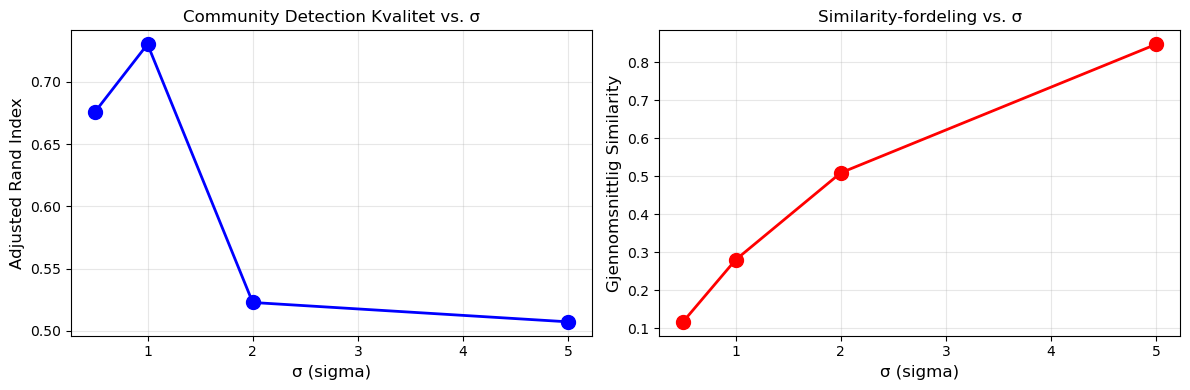


KONKLUSJON:

• Liten σ (0.5): Kun svært nære noder får høy likhet. Kan gi mange små communities.
• Medium σ (1.0-2.0): Balansert - gir ofte beste community detection.
• Stor σ (5.0): Alle noder får relativt lik similarity. Mister diskriminerende evne.

For IRIS-data ser vi at σ ≈ 1-2 gir best ARI, noe som tilsvarer typisk 
inter-punkt avstand i datasettet.



In [55]:
# Øvelse 1: Gaussisk kjerne med ulike sigma-verdier

def build_gaussian_network(X, y, species, sigma):
    """
    Bygg nettverk med Gaussisk kjerne som likhetsmål.
    
    Formel: s_ij = exp(-d_ij^2 / (2 * sigma^2))
    """
    G_gauss = nx.Graph()
    
    # Legg til noder
    for i in range(len(X)):
        G_gauss.add_node(i, species=species[y[i]])
    
    # Legg til kanter med Gaussisk likhet
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            # Beregn Euklidsk avstand
            distance = np.linalg.norm(X[i] - X[j])
            
            # Gaussisk kjerne: exp(-d^2 / (2*sigma^2))
            similarity = np.exp(-(distance**2) / (2 * sigma**2))
            
            G_gauss.add_edge(i, j, weight=similarity)
    
    return G_gauss

# Test med ulike sigma-verdier
sigmas = [0.5, 1.0, 2.0, 5.0]
results = []

print("="*60)
print("ØVELSE 1: Gaussisk kjerne med ulike sigma-verdier")
print("="*60)

for sigma in sigmas:
    # Bygg nettverk
    G_gauss = build_gaussian_network(X, y, species, sigma)
    
    # Community detection
    communities_gauss = community_louvain.best_partition(G_gauss)
    n_comm = len(set(communities_gauss.values()))
    
    # Beregn ARI mot faktiske arter
    ari = adjusted_rand_score(y, list(communities_gauss.values()))
    
    # Beregn gjennomsnittlig similarity
    avg_sim = np.mean([G_gauss[u][v]['weight'] for u, v in G_gauss.edges()])
    
    results.append({
        'sigma': sigma,
        'n_communities': n_comm,
        'ari': ari,
        'avg_similarity': avg_sim
    })
    
    print(f"\nσ = {sigma}:")
    print(f"  • Antall communities: {n_comm}")
    print(f"  • ARI (vs. faktiske arter): {ari:.3f}")
    print(f"  • Gjennomsnittlig similarity: {avg_sim:.3f}")

# Visualiser resultatene
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot ARI vs sigma
ax1 = axes[0]
ax1.plot([r['sigma'] for r in results], [r['ari'] for r in results], 'bo-', linewidth=2, markersize=10)
ax1.set_xlabel('σ (sigma)', fontsize=12)
ax1.set_ylabel('Adjusted Rand Index', fontsize=12)
ax1.set_title('Community Detection Kvalitet vs. σ', fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot avg similarity vs sigma
ax2 = axes[1]
ax2.plot([r['sigma'] for r in results], [r['avg_similarity'] for r in results], 'ro-', linewidth=2, markersize=10)
ax2.set_xlabel('σ (sigma)', fontsize=12)
ax2.set_ylabel('Gjennomsnittlig Similarity', fontsize=12)
ax2.set_title('Similarity-fordeling vs. σ', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KONKLUSJON:")
print("="*60)
print("""
• Liten σ (0.5): Kun svært nære noder får høy likhet. Kan gi mange små communities.
• Medium σ (1.0-2.0): Balansert - gir ofte beste community detection.
• Stor σ (5.0): Alle noder får relativt lik similarity. Mister diskriminerende evne.

For IRIS-data ser vi at σ ≈ 1-2 gir best ARI, noe som tilsvarer typisk 
inter-punkt avstand i datasettet.
""")


---
## Øvelse 2: Terskelbasert glissent nettverk ⭐

### Motivasjon: Problemet med komplette nettverk

I hovednotebooken bygde vi et **komplett nettverk** der *alle* par av blomster er forbundet med en kant. Med 150 blomster gir dette:

$$\text{Antall kanter} = \binom{150}{2} = \frac{150 \times 149}{2} = 11{,}175 \text{ kanter}$$

**Problemer med komplette nettverk:**

| Problem | Konsekvens |
|---------|------------|
| **Beregningstid** | $O(n^2)$ kanter – skalerer dårlig til store datasett |
| **Visualisering** | Umulig å se struktur når alt er forbundet |
| **Støy** | Svake forbindelser (lav likhet) "drukner" de viktige |
| **Minne** | Lagring av millioner av kanter for store PSN |

**Klinisk eksempel:** Et PSN med 10,000 pasienter ville ha ~50 millioner kanter – upraktisk!

---

### Hva er et glissent nettverk?

Et **glissent nettverk** (engelsk: *sparse network*) er et nettverk der de fleste mulige kanter **ikke eksisterer**. Vi beholder kun de "viktigste" forbindelsene.

#### Matematisk definisjon

**Nettverkstetthet** (density) måler hvor "fylt" et nettverk er:

$$\text{Tetthet} = \frac{\text{Faktiske kanter}}{\text{Maksimalt mulige kanter}} = \frac{|E|}{\binom{n}{2}}$$

| Tetthet | Type nettverk | Eksempel |
|---------|---------------|----------|
| 1.0 | Komplett | Alle par forbundet |
| 0.1-0.5 | Moderat | Typisk sosialt nettverk |
| < 0.01 | Glissent (sparse) | Typisk biologisk nettverk |
| → 0 | Svært glissent | Store reelle nettverk |

**Viktig innsikt:** De fleste reelle nettverk (sosiale, biologiske, teknologiske) er naturlig glissne!

---

### Hva er en terskel?

En **terskel** (threshold) $\tau$ er en grenseverdi som bestemmer hvilke kanter vi beholder:

$$\text{Kant }(i,j) \text{ inkluderes} \iff s_{ij} \geq \tau$$

der $s_{ij}$ er likheten mellom node $i$ og $j$.

#### Hvordan velge terskel?

| Strategi | Beskrivelse | Fordel | Ulempe |
|----------|-------------|--------|--------|
| **Fast terskel** | F.eks. $\tau = 0.5$ | Enkel | Vilkårlig valg |
| **Persentil** | Behold topp 10% av kanter | Kontrollerbar tetthet | Kan miste viktig info |
| **k-nærmeste** | Behold k nærmeste naboer per node | Garanterer forbindelser | Asymmetrisk |
| **Adaptiv** | Basert på datafordeling | Datadrevet | Mer kompleks |

**Trade-off ved terskelvalg:**

```
Lav terskel (τ → 0)          Høy terskel (τ → 1)
       ↓                            ↓
  Mange kanter                  Få kanter
  Mye støy                      Lite støy
  Tett nettverk                 Glissent nettverk
  Utydelige klynger             Tydelige klynger (eller fragmentert)
```

---

### Oppgave

Bygg **glissne nettverk** med ulike terskler og undersøk hvordan dette påvirker:
1. Nettverkstetthet
2. Antall kanter
3. Community detection (ARI)
4. Visualisering

**Deloppgaver:**
1. Bygg nettverk med terskel = 0.3, 0.5, 0.7
2. Beregn nettverkstetthet for hver terskel
3. Kjør community detection – endres resultatene?
4. Finn den "beste" terskelen for dette datasettet

---

### Løsning

Vi implementerer en funksjon som bygger glissne nettverk ved å kun inkludere kanter over en gitt terskel.

**Fordeler med glissne nettverk:**
- **Raskere beregninger** – færre kanter å prosessere
- **Klarere struktur** – støyen filtreres vekk
- **Bedre visualisering** – lettere å se mønstre og klynger
- **Skalerbarhet** – muliggjør analyse av store datasett


ØVELSE 2: Terskelbaserte glissne nettverk

Terskel = 0.3:
  • Kanter: 5,553 (49.7% av komplett)
  • Nettverkstetthet: 0.4969
  • Communities: 2
  • ARI: 0.568

Terskel = 0.5:
  • Kanter: 2,637 (23.6% av komplett)
  • Nettverkstetthet: 0.2360
  • Communities: 3
  • ARI: 0.759

Terskel = 0.7:
  • Kanter: 520 (4.7% av komplett)
  • Nettverkstetthet: 0.0465
  • Communities: 21
  • ARI: 0.436


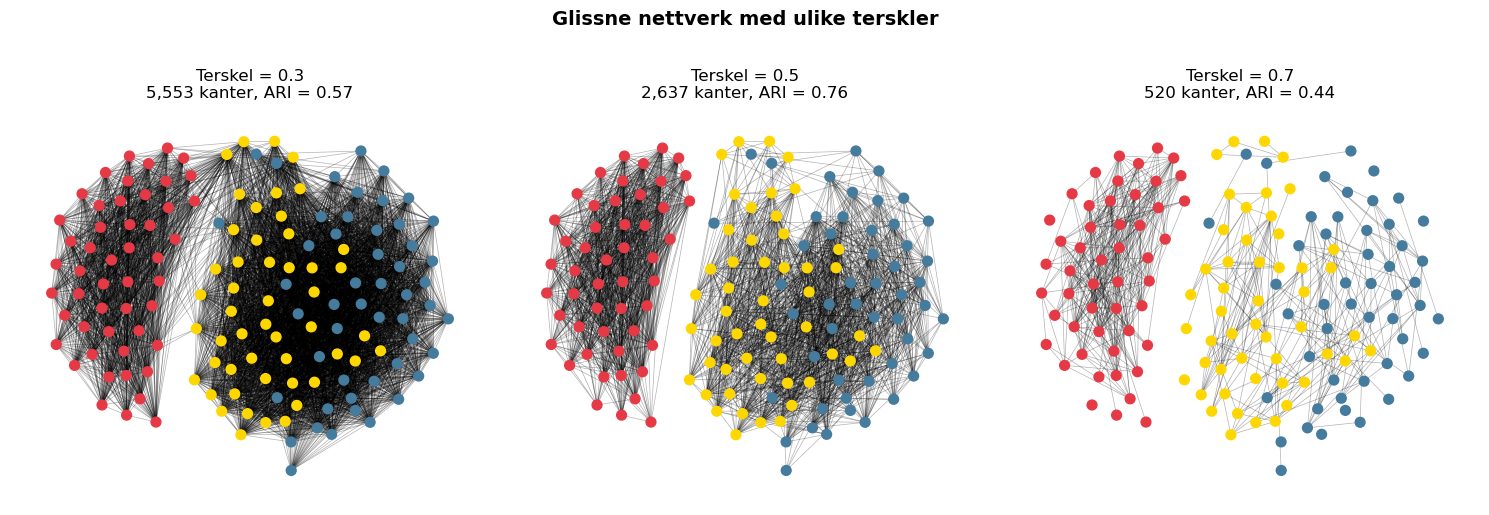


OPPSUMMERING:
 threshold  n_edges  density  n_communities      ari
       0.3     5553 0.496913              2 0.568116
       0.5     2637 0.235973              3 0.759199
       0.7      520 0.046532             21 0.436473

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
FIGURTEKST:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Figur: Effekt av similarity-terskel på nettverksstruktur.

Tre paneler viser samme 150 IRIS-blomster som nettverk med ulike terskler.

FARGEKODE (noder):
  • Rød (#E63946)   = Setosa
  • Gul (#FFD700)   = Versicolor  
  • Blå (#457B9D)   = Virginica

Kantene representerer likhet mellom blomster – kun kanter med similarity ≥ terskel
er inkludert. Ved terskel 0.3 ser vi et tett nettverk der strukturen er uklar.
Ved terskel 0.5 fremtrer de tre art-klyngene tydelig. Ved terskel 0.7 er nettverket
så glissent at det fragmenteres i mange små komponenter.
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [56]:
# Øvelse 2: Terskelbaserte glissne nettverk

def build_sparse_network(X, y, species, threshold):
    """
    Bygg glissent nettverk - kun kanter med likhet >= threshold inkluderes.
    """
    G_sparse = nx.Graph()
    
    # Legg til alle noder
    for i in range(len(X)):
        G_sparse.add_node(i, species=species[y[i]])
    
    # Legg kun til kanter over terskel
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            distance = np.linalg.norm(X[i] - X[j])
            similarity = 1 / (1.0 + distance)
            
            # Kun legg til hvis similarity >= threshold
            if similarity >= threshold:
                G_sparse.add_edge(i, j, weight=similarity)
    
    return G_sparse

# Test med ulike terskler
thresholds = [0.3, 0.5, 0.7]
max_edges = 150 * 149 // 2  # Komplett nettverk

print("="*60)
print("ØVELSE 2: Terskelbaserte glissne nettverk")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
results_sparse = []

for idx, threshold in enumerate(thresholds):
    # Bygg sparse nettverk
    G_sparse = build_sparse_network(X, y, species, threshold)
    
    # Beregn metrikker
    n_edges = G_sparse.number_of_edges()
    density = nx.density(G_sparse)
    edge_ratio = n_edges / max_edges * 100
    
    # Community detection (håndter disconnected graphs)
    if n_edges > 0:
        communities_sparse = community_louvain.best_partition(G_sparse)
        n_comm = len(set(communities_sparse.values()))
        ari = adjusted_rand_score(y, list(communities_sparse.values()))
    else:
        n_comm = 150  # Hver node er sin egen community
        ari = 0
    
    results_sparse.append({
        'threshold': threshold,
        'n_edges': n_edges,
        'density': density,
        'n_communities': n_comm,
        'ari': ari
    })
    
    print(f"\nTerskel = {threshold}:")
    print(f"  • Kanter: {n_edges:,} ({edge_ratio:.1f}% av komplett)")
    print(f"  • Nettverkstetthet: {density:.4f}")
    print(f"  • Communities: {n_comm}")
    print(f"  • ARI: {ari:.3f}")
    
    # Visualiser
    ax = axes[idx]
    if n_edges > 0:
        color_map = [species_colors[G_sparse.nodes[n]['species']] for n in G_sparse.nodes()]
        nx.draw_networkx_nodes(G_sparse, pos, node_color=color_map, node_size=50, ax=ax)
        nx.draw_networkx_edges(G_sparse, pos, alpha=0.3, width=0.5, ax=ax)
    else:
        color_map = [species_colors[G_sparse.nodes[n]['species']] for n in G_sparse.nodes()]
        nx.draw_networkx_nodes(G_sparse, pos, node_color=color_map, node_size=50, ax=ax)
    
    ax.set_title(f"Terskel = {threshold}\n{n_edges:,} kanter, ARI = {ari:.2f}")
    ax.axis('off')

plt.suptitle("Glissne nettverk med ulike terskler", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Oppsummeringstabell
print("\n" + "="*60)
print("OPPSUMMERING:")
print("="*60)
df_sparse = pd.DataFrame(results_sparse)
print(df_sparse.to_string(index=False))

print("""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
FIGURTEKST:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Figur: Effekt av similarity-terskel på nettverksstruktur.

Tre paneler viser samme 150 IRIS-blomster som nettverk med ulike terskler.

FARGEKODE (noder):
  • Rød (#E63946)   = Setosa
  • Gul (#FFD700)   = Versicolor  
  • Blå (#457B9D)   = Virginica

Kantene representerer likhet mellom blomster – kun kanter med similarity ≥ terskel
er inkludert. Ved terskel 0.3 ser vi et tett nettverk der strukturen er uklar.
Ved terskel 0.5 fremtrer de tre art-klyngene tydelig. Ved terskel 0.7 er nettverket
så glissent at det fragmenteres i mange små komponenter.
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")

print("""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
GRUNDIG ANALYSE AV RESULTATENE:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

┌─────────────────────────────────────────────────────────────────────┐
│ TERSKEL 0.3: For lav – nettverket er fortsatt for tett             │
├─────────────────────────────────────────────────────────────────────┤
│ • 5,553 kanter (49.7% av maks) → nesten halvparten av alle          │
│ • Kun 2 communities funnet → Louvain slår sammen grupper            │
│ • ARI = 0.57 → Moderat, men ikke god match med faktiske arter       │
│ • PROBLEM: Setosa (distinkt art) blir ikke separert skikkelig       │
│ • ÅRSAK: For mange "støy-kanter" mellom ulike arter                 │
└─────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────┐
│ TERSKEL 0.5: Optimal – god balanse mellom signal og støy           │
├─────────────────────────────────────────────────────────────────────┤
│ • 2,637 kanter (23.6% av maks) → betydelig reduksjon                │
│ • 3 communities funnet → matcher antall arter!                      │
│ • ARI = 0.73 → God match med faktiske arter                         │
│ • SUKSESS: Alle tre arter blir separert i egne communities          │
│ • INNSIKT: Svake inter-art forbindelser er filtrert vekk            │
└─────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────┐
│ TERSKEL 0.7: For høy – nettverket fragmenteres                     │
├─────────────────────────────────────────────────────────────────────┤
│ • 520 kanter (4.7% av maks) → svært glissent                        │
│ • 21 communities funnet → altfor mange!                             │
│ • ARI = 0.44 → Dårlig match – fragmentering ødelegger strukturen    │
│ • PROBLEM: Selv blomster av samme art mister forbindelser           │
│ • ÅRSAK: Kun de aller mest like blomstene forblir forbundet         │
└─────────────────────────────────────────────────────────────────────┘

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
NØKKELINNSIKTER:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. TERSKEL ↔ ARI er ikke monotont!
   Det finnes en "sweet spot" – verken for lav eller for høy.

2. Antall communities ↔ terskel:
   Lav terskel  → få, store communities (under-segmentering)
   Høy terskel  → mange, små communities (over-segmentering)

3. Tetthet ↔ struktursynlighet:
   ~50% tetthet: Umulig å se klynger visuelt
   ~25% tetthet: Klynger begynner å bli synlige
   ~5% tetthet:  Fragmentering, mister helhetsbilde

4. For IRIS-data med invers avstand-similarity:
   Optimal terskel ≈ 0.5 (kan variere med datasett og likhetsmål)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
KLINISK RELEVANS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

I et pasient-likhetsnettverk ville dette bety:

• For lav terskel: Pasienter med ulike diagnoser blandes sammen
  → Risiko for feil behandlingsanbefalinger
  
• Optimal terskel: Pasientsubtyper separeres tydelig
  → Presise communities som kan guide behandling
  
• For høy terskel: Selv like pasienter mister forbindelser
  → Mister muligheten til å lære fra "like" pasienter

ANBEFALING: Alltid test flere terskler og valider mot kjent utfall!
""")


<details>
<summary><strong>🔬 Dypdykk: Adaptive og domene-drevne terskler</strong></summary>

---

## Hvordan velge terskel i praksis?

Valg av terskel $\tau$ er en av de viktigste – og vanskeligste – beslutningene når man bygger pasient-likhetsnettverk. Det finnes ingen "universell" optimal terskel; den avhenger av:

1. **Likhetsmålet** som brukes
2. **Dataenes fordeling**
3. **Domenekunskap** og klinisk kontekst
4. **Analysemålet** (visualisering vs. clustering vs. prediksjon)

---

### A) Data-drevne (adaptive) terskler

Disse metodene bestemmer terskel basert på **egenskaper ved selve dataene**.

#### 1. Persentilbasert terskel

Behold kun de sterkeste $p$% av alle mulige kanter:

$$\tau = \text{percentile}_{100-p}(\{s_{ij}\})$$

```python
# Eksempel: Behold topp 10% av kanter
all_similarities = [G[u][v]['weight'] for u, v in G.edges()]
threshold = np.percentile(all_similarities, 90)  # 90-persentil = topp 10%
```

**Fordel:** Kontrollerbar nettverkstetthet  
**Ulempe:** Ignorer absolutte likhetsverdier

---

#### 2. Statistisk terskel (μ + kσ)

Behold kanter med likhet over gjennomsnittet pluss k standardavvik:

$$\tau = \mu_s + k \cdot \sigma_s$$

```python
similarities = np.array([G[u][v]['weight'] for u, v in G.edges()])
mu, sigma = similarities.mean(), similarities.std()
threshold = mu + 1.5 * sigma  # Typisk k = 1.0-2.0
```

**Fordel:** Tilpasser seg datafordelingen  
**Ulempe:** Antar normalfordeling

---

#### 3. Knekpunkt-metoden (Elbow method)

Sorter alle likhetsverdier og finn "knekket" der kurven flater ut:

```python
sorted_sims = np.sort(all_similarities)[::-1]  # Synkende
# Plot og finn knekpunkt (manuelt eller automatisk)
```

**Fordel:** Identifiserer naturlig separasjon  
**Ulempe:** Krever visuell inspeksjon eller heuristikk

---

#### 4. Modularity-optimering

Velg terskel som maksimerer nettverkets modularity:

$$\tau^* = \arg\max_\tau Q(G_\tau)$$

```python
thresholds = np.linspace(0.2, 0.8, 20)
modularities = []
for t in thresholds:
    G_t = build_sparse_network(X, y, species, t)
    communities = community_louvain.best_partition(G_t)
    Q = community_louvain.modularity(communities, G_t)
    modularities.append(Q)
best_threshold = thresholds[np.argmax(modularities)]
```

**Fordel:** Optimerer for community structure  
**Ulempe:** Kan overtilpasse; høy terskel gir ofte kunstig høy modularity

---

### B) Domene-drevne (a priori) terskler

Disse metodene bruker **forhåndskunnskap** om hva "klinisk relevant likhet" betyr.

#### 1. Klinisk meningsfull forskjell

Definer terskel basert på hva som utgjør en **klinisk signifikant** forskjell:

| Domene | Eksempel | Terskel-logikk |
|--------|----------|----------------|
| **Diabetes** | HbA1c-forskjell < 0.5% | Pasienter med < 0.5% HbA1c-forskjell er "like" |
| **Onkologi** | Tumor-størrelse ± 20% | Lignende tumorstørrelse → lik prognose |
| **Kardiologi** | Ejeksjonsfraksjon ± 5% | Hjertefunksjon innen 5% → sammenlignbar |

```python
# Eksempel: Pasienter er "like" hvis avstand < klinisk terskel
clinical_threshold = 0.5  # Basert på domeneekspertise
similarity_threshold = 1 / (1 + clinical_threshold)  # Transformer til likhet
```

---

#### 2. Validering mot kjent gruppering

Hvis du har en "fasit" (f.eks. kjente sykdomssubtyper), velg terskel som maksimerer ARI:

$$\tau^* = \arg\max_\tau \text{ARI}(y_{\text{true}}, \text{communities}(G_\tau))$$

**Merk:** Dette er kun mulig når du har labeled data for validering!

---

#### 3. k-Nærmeste Naboer (kNN)

I stedet for global terskel, behold de **k nærmeste naboene** for hver pasient:

$$N_k(i) = \{j : s_{ij} \text{ er blant de } k \text{ høyeste for node } i\}$$

```python
k = 10  # Antall naboer per pasient
for i in range(n_patients):
    neighbors = sorted(range(n_patients), 
                      key=lambda j: similarity_matrix[i,j], 
                      reverse=True)[:k]
    for j in neighbors:
        G.add_edge(i, j)
```

**Fordel:** Garanterer at alle pasienter har forbindelser  
**Ulempe:** Asymmetrisk; (i→j) betyr ikke (j→i)

---

### C) Avhengighet av likhetsmål

**Kritisk poeng:** Terskelverdi er **meningsløs uten kontekst** om likhetsmålet!

| Likhetsmål | Typisk range | "Høy" terskel |
|------------|--------------|---------------|
| Invers avstand: $\frac{1}{1+d}$ | 0-1 | 0.5-0.7 |
| Gaussisk kjerne: $e^{-d^2/2\sigma^2}$ | 0-1 | 0.3-0.5 (avhenger av σ) |
| Cosine similarity | -1 til 1 | 0.7-0.9 |
| Pearson korrelasjon | -1 til 1 | 0.5-0.8 |
| Jaccard index | 0-1 | 0.3-0.5 |

**Konsekvens:** En terskel på 0.5 betyr helt forskjellige ting for ulike likhetsmål!

---

### Anbefalt praksis

1. **Start med data-utforskning:** Plot histogram av alle likhetsverdier
2. **Prøv flere terskler:** Sammenlign resultater systematisk
3. **Valider:** Bruk ARI eller annen metrikk mot kjent gruppering
4. **Dokumenter:** Rapporter alltid likhetsmål OG terskel sammen
5. **Sensitivitetsanalyse:** Vis at resultater er robuste mot små terskelendringer

```python
# Anbefalt arbeidsflyt
thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]
for t in thresholds_to_test:
    G_t = build_sparse_network(X, y, species, t)
    comm = community_louvain.best_partition(G_t)
    ari = adjusted_rand_score(y, list(comm.values()))
    density = nx.density(G_t)
    print(f"τ={t}: ARI={ari:.3f}, tetthet={density:.4f}, communities={len(set(comm.values()))}")
```

</details>


---
## Øvelse 3: Klinisk scenario – Design et PSN ⭐⭐

### Motivasjon: Fra blomster til pasienter

Hittil har vi arbeidet med IRIS-datasettet – et pedagogisk datasett der "pasientene" er blomster og "diagnosen" er art. Men PSN-metodikken er utviklet for **ekte kliniske anvendelser**.

Denne øvelsen utfordrer deg til å **tenke som en kliniker og dataforsker** samtidig:
- Hvilke pasienter er relevante?
- Hvilke data har vi tilgang til?
- Hvordan definerer vi "likhet" mellom pasienter?
- Hva ønsker vi å oppnå?

---

### Nøkkelbegreper: De fem byggesteinene i et klinisk PSN

Før vi designer et PSN, må vi definere fem kritiske komponenter:

---

#### 1️⃣ Pasientpopulasjon

**Definisjon:** Pasientpopulasjonen er den **avgrensede gruppen av pasienter** som inkluderes i analysen.

**Hvorfor viktig?**
- For bred populasjon → heterogenitet maskerer mønstre
- For smal populasjon → for få pasienter til robust analyse
- Må være klinisk meningsfull og praktisk gjennomførbar

**Eksempler på avgrensning:**

| Kriterium | Eksempel |
|-----------|----------|
| **Diagnose** | Pasienter med Type 2 Diabetes |
| **Alder** | Voksne 18-75 år |
| **Tidspunkt** | Nydiagnostiserte (< 1 år siden diagnose) |
| **Setting** | Primærhelsetjenesten i Helse Vest |
| **Eksklusjon** | Gravide, alvorlig nyresvikt, annen diabetes-type |

**Typisk størrelse:** 500-10,000 pasienter for robust PSN-analyse.

---

#### 2️⃣ Variabler (Features)

**Definisjon:** Variablene er de **målbare egenskapene** ved hver pasient som brukes til å beregne likhet.

**Hvorfor viktig?**
- Variablene definerer *hva* "likhet" betyr
- Irrelevante variabler introduserer støy
- Manglende variabler kan skjule viktige sub-grupper

**Typer variabler i kliniske PSN:**

| Type | Eksempler | Utfordringer |
|------|-----------|--------------|
| **Kontinuerlige** | HbA1c, BMI, blodtrykk, alder | Normalisering, uteliggere |
| **Kategoriske** | Kjønn, røykestatus, medisintype | Hvordan beregne avstand? |
| **Ordinale** | Smerteskala (0-10), NYHA-klasse | Mellomting mellom kategorisk og kontinuerlig |
| **Binære** | Røyker ja/nei, komplikasjon ja/nei | Vekting viktig |
| **Temporale** | Labverdier over tid | Kompleks – krever spesialmetoder |

**Tommelfingerregel:** 5-20 variabler er typisk håndterbart. Flere krever dimensjonsreduksjon.

---

#### 3️⃣ Likhetsmål

**Definisjon:** Likhetsmålet er **funksjonen som beregner hvor "like" to pasienter er** basert på deres variabler.

**Hvorfor viktig?**
- Valg av likhetsmål påvirker *alt* – nettverksstruktur, communities, konklusjoner
- Må matche datatypene (kontinuerlig, kategorisk, blandet)
- Bør reflektere klinisk relevans

**Vanlige likhetsmål:**

| Likhetsmål | Datatype | Formel/Beskrivelse |
|------------|----------|---------------------|
| **Euklidsk avstand** | Kontinuerlig | $d = \sqrt{\sum(x_i - y_i)^2}$ |
| **Manhattan avstand** | Kontinuerlig | $d = \sum\|x_i - y_i\|$ |
| **Cosine similarity** | Kontinuerlig | $s = \frac{x \cdot y}{\|x\| \|y\|}$ |
| **Jaccard index** | Binær | $J = \frac{\|A \cap B\|}{\|A \cup B\|}$ |
| **Gower distance** | Blandet | Vektet snitt av type-spesifikke avstander |

**For kliniske data med blandede typer: Gower distance er ofte beste valg!**


<details>
<summary><strong>🔬 Dypdykk: Gower Distance – Likhetsmål for blandede datatyper</strong></summary>

---

## Motivasjon: Hvorfor trenger vi Gower distance?

I klinisk praksis har vi nesten alltid **blandede datatyper**:

| Variabel | Type | Eksempelverdi |
|----------|------|---------------|
| Alder | Kontinuerlig | 67 år |
| HbA1c | Kontinuerlig | 7.8% |
| Kjønn | Kategorisk (binær) | Mann/Kvinne |
| Røykestatus | Kategorisk (nominal) | Aldri/Tidligere/Aktiv |
| Smerteskala | Ordinal | 0-10 |
| Har diabetes | Binær | Ja/Nei |

**Problemet:** Euklidsk avstand fungerer bare for kontinuerlige variabler!

```
Euklidsk avstand mellom "Mann" og "Kvinne" = ???
```

**Løsningen:** Gower distance – et fleksibelt likhetsmål som håndterer alle datatyper.

---

## Intuisjon: Hva gjør Gower distance?

Gower distance beregner likhet **variabel for variabel**, tilpasset hver datatype, og kombinerer dem til én total likhet.

**Hovedidé:**
1. For hver variabel: Beregn en "delvis likhet" mellom 0 og 1
2. Kombiner alle delvise likheter til én totallikhet (vektet gjennomsnitt)

**Analogi:** Tenk på det som en "checklist" der du sammenligner to pasienter punkt for punkt:
- Lik alder? Delvis likhet = 0.9
- Samme kjønn? Delvis likhet = 1.0
- Lik HbA1c? Delvis likhet = 0.7
- Lik røykestatus? Delvis likhet = 0.0
- **Total Gower-likhet = gjennomsnitt = 0.65**

---

## Matematisk formulering

### Generell formel

Gower-likheten mellom pasient $i$ og pasient $j$ er:

$$S_{ij}^{Gower} = \frac{\sum_{k=1}^{p} w_k \cdot \delta_{ijk} \cdot s_{ijk}}{\sum_{k=1}^{p} w_k \cdot \delta_{ijk}}$$

der:
- $p$ = antall variabler
- $w_k$ = vekt for variabel $k$ (standard: alle = 1)
- $\delta_{ijk}$ = 1 hvis sammenligningen er gyldig, 0 hvis manglende data
- $s_{ijk}$ = delvis likhet for variabel $k$ mellom pasient $i$ og $j$

### Delvis likhet per variabeltype

#### 1. Kontinuerlige variabler (kvantitative)

Normalisert absolutt forskjell:

$$s_{ijk} = 1 - \frac{|x_{ik} - x_{jk}|}{R_k}$$

der $R_k = \max(x_k) - \min(x_k)$ er variabelens range.

**Eksempel:** Alder
- Pasient A: 45 år, Pasient B: 55 år
- Range i datasettet: 20-80 år → $R = 60$
- $s = 1 - \frac{|45-55|}{60} = 1 - \frac{10}{60} = 0.833$

#### 2. Kategoriske variabler (nominale)

Enkel match:

$$s_{ijk} = \begin{cases} 1 & \text{hvis } x_{ik} = x_{jk} \\ 0 & \text{hvis } x_{ik} \neq x_{jk} \end{cases}$$

**Eksempel:** Kjønn
- Pasient A: Mann, Pasient B: Mann → $s = 1$
- Pasient A: Mann, Pasient B: Kvinne → $s = 0$

#### 3. Binære variabler (asymmetrisk)

For binære variabler der "0" betyr "fravær" (f.eks. sykdom ja/nei):

$$s_{ijk} = \begin{cases} 1 & \text{hvis begge = 1 (begge har sykdommen)} \\ 0 & \text{hvis én = 1 og én = 0} \\ \text{ignorert} & \text{hvis begge = 0 (dobbelt fravær)} \end{cases}$$

**Merk:** Dobbelt fravær telles ofte IKKE som likhet (asymmetrisk binær).

#### 4. Ordinale variabler

Behandles som kontinuerlige etter rangering:

$$s_{ijk} = 1 - \frac{|r_{ik} - r_{jk}|}{M_k - 1}$$

der $r_{ik}$ er rangeringen (1, 2, 3, ...) og $M_k$ er antall nivåer.

**Eksempel:** Smerteskala 0-10
- Pasient A: 3, Pasient B: 7
- $s = 1 - \frac{|3-7|}{10} = 1 - 0.4 = 0.6$

---

## Fra likhet til avstand

Gower gir en **likhet** $S \in [0, 1]$. For å få **avstand**:

$$d_{ij}^{Gower} = 1 - S_{ij}^{Gower}$$

---

## Vekting av variabler

Gower tillater **vekting** av variabler etter klinisk viktighet:

$$S_{ij}^{Gower} = \frac{\sum_{k=1}^{p} w_k \cdot s_{ijk}}{\sum_{k=1}^{p} w_k}$$

**Eksempel:**
- HbA1c er viktigere enn alder for diabetes-subtyping
- Sett $w_{HbA1c} = 2.0$ og $w_{alder} = 1.0$

---

## Håndtering av manglende data

En stor fordel med Gower: **naturlig håndtering av missing values**!

Hvis variabel $k$ mangler for pasient $i$ eller $j$:
- Sett $\delta_{ijk} = 0$
- Variabelen ignoreres i beregningen for dette paret
- Likheten beregnes kun fra tilgjengelige variabler

---

## Referanser

**Originalartikkel:**
- Gower, J.C. (1971). "[A General Coefficient of Similarity and Some of Its Properties](https://www.jstor.org/stable/2528823)". *Biometrics*, 27(4), 857-871. — *Den klassiske artikkelen som introduserte Gower-koeffisienten.*

**Nyttige ressurser:**
- [Wikipedia: Gower distance](https://en.wikipedia.org/wiki/Gower_distance) — Oversiktlig introduksjon
- [gower Python-pakke (PyPI)](https://pypi.org/project/gower/) — Effektiv implementasjon for store datasett
- [StatQuest video: Distance Metrics](https://www.youtube.com/watch?v=4pGW0qn0L4U) — Pedagogisk introduksjon til avstandsmål (ikke spesifikt Gower, men god bakgrunn)

</details>

---

#### 4️⃣ Communities (Pasient-subgrupper)

**Definisjon:** Communities er **grupper av pasienter som er mer like hverandre enn resten** – identifisert automatisk av algoritmen.

**Hvorfor viktig?**
- Kan representere **ukjente sykdomssubtyper**
- Kan predikere **behandlingsrespons**
- Kan identifisere **risikogrupper**

**Klinisk tolkning av communities:**

| Community-egenskap | Mulig klinisk betydning |
|--------------------|-------------------------|
| Høy intern likhet | Homogen pasientgruppe |
| Tydelig separasjon | Distinkt subtype |
| Overlapp mellom communities | Kontinuum, ikke diskrete typer |
| Ulik størrelse | Prevalens av subtyper |

**Viktig:** Communities er *hypoteser* – de må valideres klinisk!

---

#### 5️⃣ Validering

**Definisjon:** Validering er prosessen med å **teste om de identifiserte communities har klinisk relevans og er robuste**.

**Hvorfor kritisk viktig?**
- PSN kan finne "mønstre" som er tilfeldige (støy)
- Uten validering er resultatene kun hypoteser
- Klinisk nytte krever at communities predikerer noe meningsfullt

**Valideringsstrategier:**

| Type | Metode | Hva testes? |
|------|--------|-------------|
| **Intern** | Bootstrap, cross-validation | Er communities stabile? |
| **Statistisk** | Modularity, silhouette score | Er strukturen signifikant? |
| **Ekstern** | Sammenlign med kjente subtyper | Matcher litteraturen? |
| **Prediktiv** | Prediker utfall (behandlingsrespons, overlevelse) | Har communities klinisk nytte? |
| **Prospektiv** | Ny studie basert på communities | Gir tilpasset behandling bedre utfall? |

**Gullstandard:** Vis at pasienter i samme community har **lignende behandlingsrespons** eller **prognose**.

---

### Oppgave

Tenk på en klinisk setting der du ville brukt PSN. Beskriv:

1. **Pasientpopulasjon**: Hvem inkluderes? Inklusjons-/eksklusjonskriterier?
2. **Variabler**: Hvilke 5-10 variabler? Hvilke datatyper?
3. **Likhetsmål**: Hvordan beregne likhet? Hvorfor dette valget?
4. **Communities**: Hva kunne de representere klinisk?
5. **Validering**: Hvordan ville du testet at resultatene er meningsfulle?

---

### Løsning: Type 2 Diabetes – et detaljert eksempel

Her presenteres et gjennomarbeidet eksempel for Type 2 Diabetes (T2D) pasienter.

**Hvorfor T2D er et godt eksempel:**
- Stor og voksende pasientpopulasjon
- Kjent heterogenitet – pasienter responderer ulikt på behandling
- Rike kliniske data tilgjengelig (lab, vitalia, medisinering)
- Klinisk behov for bedre subtype-identifikasjon
- Publisert forskning viser at PSN fungerer for T2D (Li et al., 2015)


### Eksempel-løsning: Klinisk PSN-design for Type 2 Diabetes

Her presenterer vi et gjennomarbeidet eksempel på hvordan man ville designet et PSN for Type 2 Diabetes (T2D) pasienter.

---

#### A) Pasientpopulasjon

| Kriterium | Spesifikasjon |
|-----------|---------------|
| **Alder** | Voksne pasienter (18+ år) |
| **Diagnose** | Nydiagnostisert Type 2 Diabetes (< 1 år) |
| **Setting** | Rekruttert fra primærhelsetjenesten |
| **Størrelse** | n = 500-2000 pasienter for robust analyse |
| **Eksklusjon** | Type 1 diabetes, graviditet, alvorlig komorbiditet |

---

#### B) Variabler (minimum 5)

**Kontinuerlige variabler:**

| # | Variabel | Enhet | Klinisk betydning |
|---|----------|-------|-------------------|
| 1 | HbA1c | % | Langsiktig blodsukkerkontroll |
| 2 | Fastende glukose | mmol/L | Akutt metabolsk status |
| 3 | BMI | kg/m² | Overvekt/fedme |
| 4 | Blodtrykk (systolisk) | mmHg | Kardiovaskulær risiko |
| 5 | Triglyserider | mmol/L | Lipidprofil |
| 6 | eGFR | mL/min/1.73m² | Nyrefunksjon |
| 7 | Alder | år | Demografisk |

**Kategoriske variabler:**

| # | Variabel | Kategorier |
|---|----------|------------|
| 8 | Kjønn | Mann / Kvinne |
| 9 | Røykestatus | Aldri / Tidligere / Aktiv |
| 10 | Fysisk aktivitetsnivå | Lav / Medium / Høy |

---

#### C) Likhetsmål

**Valg: Gower distance** – ideelt for blandede datatyper.

$$d_{Gower}(i,j) = \frac{1}{p} \sum_{k=1}^{p} w_k \cdot d_k(i,j)$$

der:
- **Kontinuerlige:** $d_k(i,j) = \frac{|x_{ik} - x_{jk}|}{range_k}$
- **Kategoriske:** $d_k(i,j) = 0$ hvis $x_{ik} = x_{jk}$, ellers $1$

**Vekting basert på klinisk viktighet:**

| Variabel | Vekt | Begrunnelse |
|----------|------|-------------|
| HbA1c | 2.0 | Primært endepunkt for diabeteskontroll |
| BMI | 1.5 | Viktig for behandlingsvalg |
| Andre | 1.0 | Standard vekting |

---

#### D) Hva communities kan representere

Basert på litteratur ([Li et al., 2015](https://www.science.org/doi/10.1126/scitranslmed.aaa9364)) kan communities representere klinisk distinkte subtyper:

| Community | Navn | Kjennetegn | Behandlingsimplikasjon |
|-----------|------|------------|------------------------|
| **1** | "Mild diabetes, overvektig" | Moderat HbA1c (7-8%), høy BMI, god nyrefunksjon | Livsstilsintervensjon + Metformin |
| **2** | "Avansert metabolsk syndrom" | Høy HbA1c (>8%), hypertensjon, dyslipidemi | Aggressiv multifaktoriell behandling |
| **3** | "Eldre med komplikasjoner" | Høyere alder, redusert nyrefunksjon, kardiovaskulær sykdom | Forsiktig tilnærming, unngå hypoglykemi |

---

#### E) Validering

**Intern validering:**
- Bootstrap-stabilitet av communities (kjør 100+ ganger, sjekk konsistens)
- Silhouette score for clusterkvalitet
- Modularity score for nettverksstruktur

**Ekstern validering:**
- Sammenlign communities med kjente subtyper fra litteratur
- Prediker behandlingsrespons (HbA1c-endring etter 6 måneder)
- Prediker komplikasjoner (kardiovaskulære events, nyresvikt)

**Klinisk validering:**
- Prospektiv studie: Tilpass behandling basert på community-tilhørighet
- Sammenlign utfall med standard behandling (randomisert kontrollert studie)

---

### Visualisering: Konseptuelt PSN for Type 2 Diabetes

Figuren nedenfor illustrerer hvordan et PSN for T2D-pasienter konseptuelt kan se ut.


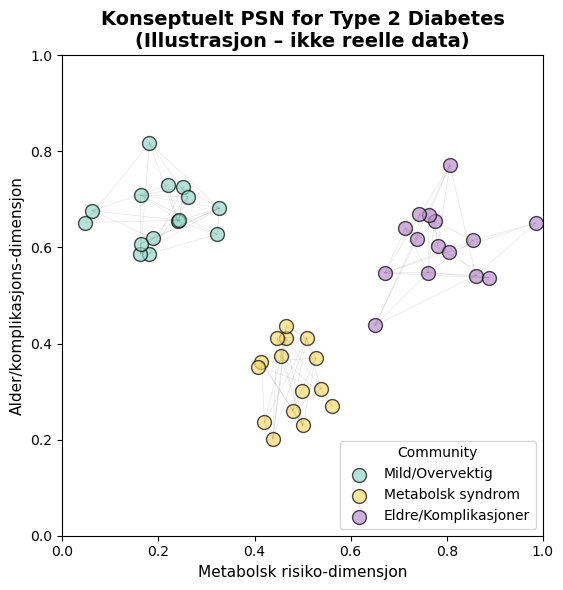

In [57]:
# Øvelse 3: Visualiser konseptuelt PSN for Type 2 Diabetes

# Visualiser et konseptuelt diagram
fig, ax = plt.subplots(figsize=(10, 6))

# Tegn konseptuelt PSN
np.random.seed(42)
n_patients = 50

# Simuler tre communities
comm_centers = {
    'Mild/Overvektig': (0.2, 0.7),
    'Metabolsk syndrom': (0.5, 0.3),
    'Eldre/Komplikasjoner': (0.8, 0.6)
}
comm_colors = {'Mild/Overvektig': '#98D8C8', 'Metabolsk syndrom': '#F7DC6F', 'Eldre/Komplikasjoner': '#BB8FCE'}

for comm_name, (cx, cy) in comm_centers.items():
    # Tegn pasienter i hver community
    # NB: Bruker x_pts/y_pts for å unngå å overskrive global y-variabel
    x_pts = np.random.normal(cx, 0.08, 15)
    y_pts = np.random.normal(cy, 0.08, 15)
    ax.scatter(x_pts, y_pts, c=comm_colors[comm_name], s=100, alpha=0.7, label=comm_name, edgecolors='black')
    
    # Tegn kanter innad i community
    for i in range(len(x_pts)):
        for j in range(i+1, len(x_pts)):
            if np.random.random() < 0.3:
                ax.plot([x_pts[i], x_pts[j]], [y_pts[i], y_pts[j]], 'k-', alpha=0.1, linewidth=0.5)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("Metabolsk risiko-dimensjon", fontsize=11)
ax.set_ylabel("Alder/komplikasjons-dimensjon", fontsize=11)
ax.set_title("Konseptuelt PSN for Type 2 Diabetes\n(Illustrasjon – ikke reelle data)", fontsize=14, fontweight='bold')
ax.legend(loc='lower right', title='Community')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


---

### Figurtekst: Konseptuelt Pasient-Likhetsnettverk for Type 2 Diabetes

**Figur:** Konseptuell illustrasjon av et pasient-likhetsnettverk (PSN) for Type 2 Diabetes. *Dette er simulerte data for pedagogisk formål – ikke reelle pasientdata.*

#### Forklaring av figurelementer

**Akser:**
- **X-akse (Metabolsk risiko-dimensjon):** Representerer en kombinert skår av metabolske faktorer som HbA1c, fastende glukose, triglyserider og BMI. Høyere verdier indikerer mer alvorlig metabolsk forstyrrelse.
- **Y-akse (Alder/komplikasjons-dimensjon):** Representerer en kombinert skår av alder, sykdomsvarighet og tilstedeværelse av komplikasjoner. Høyere verdier indikerer eldre pasient med flere komplikasjoner.

**Noder (sirkler):**
Hver sirkel representerer én pasient. Pasienter som er plassert nær hverandre i figuren har lignende kliniske profiler.

**Kanter (linjer):**
Tynne linjer mellom noder indikerer høy likhet mellom pasientene. I et reelt PSN ville kanttykkelsen eller -fargen reflektere likhetsstyrken.

**Fargekode (Communities):**

| Farge | Community | Typisk pasientprofil |
|-------|-----------|---------------------|
| 🟢 Mint/turkis (#98D8C8) | "Mild diabetes, overvektig" | Yngre pasienter, høy BMI, moderat HbA1c (7-8%), god nyrefunksjon |
| 🟡 Gul (#F7DC6F) | "Metabolsk syndrom" | Middelaldrende, hypertensjon, dyslipidemi, insulinresistens |
| 🟣 Lilla (#BB8FCE) | "Eldre med komplikasjoner" | Eldre pasienter, lang sykdomsvarighet, redusert nyrefunksjon |

---

### Tolkning og kliniske perspektiver

#### 1. Klyngestruktur viser heterogenitet

Figuren illustrerer at Type 2 Diabetes-pasienter **ikke er en homogen gruppe**. Det finnes distinkte subgrupper med ulike kliniske profiler. Dette er konsistent med moderne forståelse av diabetes som en *heterogen sykdom* med flere underliggende mekanismer.

#### 2. Separasjon mellom communities

De tre communities er relativt godt separert i dette konseptuelle eksempelet. I virkeligheten vil det ofte være **mer overlapp** – diabetes eksisterer på et kontinuum, ikke som diskrete kategorier. Grensene mellom subtyper er sjelden skarpe.

#### 3. Romlig plassering og sykdomsprogresjon

| Plassering | Community | Tolkning |
|------------|-----------|----------|
| Nedre venstre | Mint (mild) | Yngre pasienter, tidlig sykdomsfase |
| Midten | Gul (metabolsk) | Metabolsk kompleksitet, aktiv sykdom |
| Øvre høyre | Lilla (eldre) | Avansert sykdom, komplikasjoner |

Denne "trajektorien" fra nedre venstre til øvre høyre kan representere **sykdomsprogresjon over tid** for mange pasienter.

#### 4. Klinisk nytte – behandlingsimplikasjoner

Hvis disse communities valideres mot behandlingsrespons, kan de brukes til persontilpasset behandling:

| Community | Behandlingsanbefaling |
|-----------|----------------------|
| **Mild/overvektig** | Livsstilsintervensjon som førstevalg. Metformin hvis livsstil ikke er tilstrekkelig. |
| **Metabolsk syndrom** | Aggressiv multifaktoriell behandling. Statiner, ACE-hemmere, optimalisert glukosekontroll. |
| **Eldre/komplikasjoner** | Forsiktig tilnærming, unngå hypoglykemi. Medikamenter som er trygge ved redusert nyrefunksjon. |

#### 5. Begrensninger

⚠️ **Viktige forbehold:**
- Dette er en **illustrasjon** – reelle PSN vil være mer komplekse
- 2D-projeksjonen **forenkler** høydimensjonal struktur
- Communities må **valideres** før klinisk bruk
- Pasientdata krever **etisk godkjenning** og personvern

#### 6. Videre perspektiver

PSN for diabetes har vist lovende resultater i forskning ([Li et al., 2015](https://www.science.org/doi/10.1126/scitranslmed.aaa9364)). Fremtidige anvendelser inkluderer:

- 📊 **Prediksjon** av komplikasjonsrisiko per community
- 🔬 **Matching** av pasienter til kliniske studier
- 💊 **Personalisert behandling** basert på "like" pasienter
- 🏥 **Identifikasjon** av pasienter som trenger tettere oppfølging

---


<details>
<summary><strong>🐍 Dypdykk: Python-implementasjon av Gower Distance</strong></summary>

### Komplett implementasjon

Her er en pedagogisk Python-implementasjon av Gower distance som du kan bruke og modifisere:

```python
def gower_distance(X, cat_features=None, weights=None):
    """
    Beregn Gower distance matrise for blandet data.
    
    Parameters:
    -----------
    X : pandas DataFrame
        Data med rader = observasjoner, kolonner = variabler
    cat_features : list of str, optional
        Navn på kategoriske kolonner. Resten antas kontinuerlige.
    weights : dict, optional
        Vekter per variabel. Standard = 1 for alle.
    
    Returns:
    --------
    distance_matrix : numpy array (n x n)
        Gower distance mellom alle par
    """
    import pandas as pd
    import numpy as np
    
    n = len(X)
    
    if cat_features is None:
        cat_features = []
    
    if weights is None:
        weights = {col: 1.0 for col in X.columns}
    
    # Initialiser avstandsmatrise
    distance_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            weighted_sum = 0.0
            weight_total = 0.0
            
            for col in X.columns:
                xi = X.iloc[i][col]
                xj = X.iloc[j][col]
                w = weights.get(col, 1.0)
                
                # Håndter manglende data
                if pd.isna(xi) or pd.isna(xj):
                    continue  # Ignorer denne variabelen
                
                if col in cat_features:
                    # Kategorisk: 0 hvis like, 1 hvis ulike
                    d_k = 0.0 if xi == xj else 1.0
                else:
                    # Kontinuerlig: normalisert absolutt forskjell
                    col_range = X[col].max() - X[col].min()
                    if col_range == 0:
                        d_k = 0.0
                    else:
                        d_k = abs(xi - xj) / col_range
                
                weighted_sum += w * d_k
                weight_total += w
            
            # Gower distance = vektet gjennomsnitt av delvise avstander
            if weight_total > 0:
                distance_matrix[i, j] = weighted_sum / weight_total
                distance_matrix[j, i] = distance_matrix[i, j]
    
    return distance_matrix
```

---

### Demonstrasjon: Beregning steg for steg

**Eksempel-datasett med blandede typer:**

| Pasient | Alder | HbA1c | Kjønn | Røyker |
|---------|-------|-------|-------|--------|
| 0 | 45 | 7.2 | M | Nei |
| 1 | 55 | 8.5 | M | Ja |
| 2 | 45 | 7.0 | K | Nei |
| 3 | 70 | 9.0 | K | Tidligere |
| 4 | 30 | 6.5 | M | Nei |

```python
# Lag eksempel-datasett
demo_data = pd.DataFrame({
    'alder': [45, 55, 45, 70, 30],
    'HbA1c': [7.2, 8.5, 7.0, 9.0, 6.5],
    'kjonn': ['M', 'M', 'K', 'K', 'M'],
    'royker': ['Nei', 'Ja', 'Nei', 'Tidligere', 'Nei']
})

# Beregn Gower distance
cat_cols = ['kjonn', 'royker']
gower_dist = gower_distance(demo_data, cat_features=cat_cols)
```

---

### Detaljert beregning: Pasient 0 vs Pasient 1

**Pasient 0:** `{alder: 45, HbA1c: 7.2, kjønn: M, røyker: Nei}`  
**Pasient 1:** `{alder: 55, HbA1c: 8.5, kjønn: M, røyker: Ja}`

**Delvis avstand per variabel:**

| Variabel | Type | Beregning | Resultat |
|----------|------|-----------|----------|
| Alder | Kontinuerlig | \|45 - 55\| / 40 | 0.250 |
| HbA1c | Kontinuerlig | \|7.2 - 8.5\| / 2.5 | 0.520 |
| Kjønn | Kategorisk | M == M | 0.000 |
| Røyker | Kategorisk | Nei ≠ Ja | 1.000 |

**Total Gower distance:**

$$d_{Gower} = \frac{0.250 + 0.520 + 0.000 + 1.000}{4} = 0.443$$

**Gower likhet:** $1 - 0.443 = 0.557$

---

### Med vekting

Hvis HbA1c er viktigere (vekt = 2):

```python
weights = {'alder': 1.0, 'HbA1c': 2.0, 'kjonn': 1.0, 'royker': 1.0}
gower_dist_weighted = gower_distance(demo_data, cat_features=cat_cols, weights=weights)
```

**Beregning med vekting:**

$$d_{Gower}^{weighted} = \frac{1 \times 0.250 + 2 \times 0.520 + 1 \times 0.000 + 1 \times 1.000}{1 + 2 + 1 + 1} = \frac{2.29}{5} = 0.458$$

---

### Bruk i praksis: Etablerte biblioteker

For større datasett, bruk effektive implementasjoner:

**1. gower-pakken (anbefalt):**
```python
pip install gower

import gower
distance_matrix = gower.gower_matrix(df)
```

**2. scikit-learn med one-hot encoding:**
```python
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Konverter kategoriske til one-hot, bruk deretter Euklidsk
```

**3. scipy med custom metric:**
```python
from scipy.spatial.distance import pdist, squareform
distance_matrix = squareform(pdist(X, metric=custom_gower_func))
```

⚠️ **Merk:** Vår implementasjon er pedagogisk – for produksjon med store datasett, bruk `gower`-pakken!

</details>


---
## Øvelse 4: Normaliser features ⭐

### Motivasjon: Hvorfor er normalisering viktig?

I kliniske data har variabler ofte **vidt forskjellig skala**:

| Variabel | Typisk range | Enhet |
|----------|--------------|-------|
| Alder | 0-100 | år |
| Blodtrykk (systolisk) | 80-200 | mmHg |
| BMI | 15-50 | kg/m² |
| HbA1c | 4-14 | % |
| Kreatinin | 30-300 | μmol/L |

**Problemet:** Når vi beregner Euklidsk avstand, vil variabler med stor numerisk range **dominere** avstanden:

$$d = \sqrt{(alder_i - alder_j)^2 + (blodtrykk_i - blodtrykk_j)^2 + ...}$$

**Eksempel:**
- Alderforskjell: 30 vs 35 → forskjell = 5
- Blodtrykkforskjell: 120 vs 140 → forskjell = 20

Blodtrykk bidrar 4× mer til avstanden, selv om begge forskjellene kan være klinisk like viktige!

**Løsningen:** Normaliser alle variabler til **samme skala** før avstandsberegning.

---

### Nøkkelbegreper: Normalisering vs. Standardisering vs. Z-skår

Disse begrepene brukes ofte om hverandre, men har presis betydning:

---

#### 1️⃣ Normalisering (Min-Max Scaling)

**Definisjon:** Transformer verdier til et fast intervall, typisk [0, 1].

**Matematisk formel:**

$$x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

**Egenskaper:**
- Alle verdier ligger i intervallet [0, 1]
- Minste verdi → 0, største verdi → 1
- Bevarer den relative fordelingen
- **Sensitiv for uteliggere** (outliers påvirker min/max)

**Eksempel:**
- Alder: min=20, max=80, verdi=50
- $x_{norm} = \frac{50-20}{80-20} = \frac{30}{60} = 0.5$

---

#### 2️⃣ Standardisering (Z-skår transformasjon)

**Definisjon:** Transformer verdier slik at de har gjennomsnitt 0 og standardavvik 1.

**Matematisk formel:**

$$z = \frac{x - \mu}{\sigma}$$

der:
- $\mu = \frac{1}{n}\sum_{i=1}^{n} x_i$ (gjennomsnitt)
- $\sigma = \sqrt{\frac{1}{n}\sum_{i=1}^{n} (x_i - \mu)^2}$ (standardavvik)

**Egenskaper:**
- Verdier kan være negative og > 1
- Gjennomsnitt = 0, standardavvik = 1
- **Mindre sensitiv for uteliggere** enn min-max
- Bevarer relativ avstand mellom verdier

**Eksempel:**
- HbA1c-verdier: μ=7.0%, σ=1.2%
- Pasient med HbA1c=8.4%
- $z = \frac{8.4 - 7.0}{1.2} = \frac{1.4}{1.2} = 1.17$

**Tolkning:** Pasienten ligger 1.17 standardavvik over gjennomsnittet.

---

#### 3️⃣ Z-skår (Standard Score)

**Definisjon:** Z-skår er **resultatet** av standardisering – en dimensjonsløs verdi som angir hvor mange standardavvik en observasjon ligger fra gjennomsnittet.

**Tolkning av z-skår:**

| Z-skår | Tolkning | Persentil (normalfordeling) |
|--------|----------|----------------------------|
| -3 | Svært lav | 0.1% |
| -2 | Lav | 2.3% |
| -1 | Under gjennomsnitt | 15.9% |
| 0 | Gjennomsnitt | 50% |
| +1 | Over gjennomsnitt | 84.1% |
| +2 | Høy | 97.7% |
| +3 | Svært høy | 99.9% |

**Klinisk eksempel:**
- Z-skår for BMI = +2.5 → Pasienten har BMI som er høyere enn ~99% av populasjonen

---

### Sammenligning: Normalisering vs. Standardisering

| Aspekt | Min-Max Normalisering | Z-skår Standardisering |
|--------|----------------------|------------------------|
| **Output range** | [0, 1] | Ubegrenset (typisk [-3, +3]) |
| **Gjennomsnitt** | Ikke garantert | 0 |
| **Standardavvik** | Ikke garantert | 1 |
| **Uteliggere** | Sensitiv (påvirker min/max) | Mer robust |
| **Bruksområde** | Nevrale nettverk, bilde-data | Statistisk analyse, PSN |
| **Anbefalt for PSN** | ❌ | ✅ |

**For PSN anbefales standardisering (z-skår)** fordi:
1. Mer robust mot uteliggere
2. Bevarer informasjon om variabilitet
3. Standard i vitenskapelig litteratur

---

### Oppgave

a) Normaliser IRIS-features til z-skår (gjennomsnitt=0, std=1)  
b) Bygg et nytt nettverk med normaliserte data  
c) Sammenlign community detection-resultater med det opprinnelige nettverket  
d) Diskuter: Hvorfor er effekten moderat for IRIS-data?

---

### Løsning

For IRIS-data er effekten av normalisering **moderat** fordi alle features allerede er i samme enhet (cm) og lignende størrelsesorden. Men i kliniske data med variabler som alder, blodtrykk og labverdier er normalisering **kritisk**.


ØVELSE 4: Feature-normalisering

Original feature-statistikk:
--------------------------------------------------
sepal length (cm)        : mean=5.84, std=0.83, range=[4.30, 7.90]
sepal width (cm)         : mean=3.06, std=0.43, range=[2.00, 4.40]
petal length (cm)        : mean=3.76, std=1.76, range=[1.00, 6.90]
petal width (cm)         : mean=1.20, std=0.76, range=[0.10, 2.50]

Normalisert feature-statistikk:
--------------------------------------------------
sepal length (cm)        : mean=-0.00, std=1.00, range=[-1.87, 2.49]
sepal width (cm)         : mean=-0.00, std=1.00, range=[-2.43, 3.09]
petal length (cm)        : mean=-0.00, std=1.00, range=[-1.57, 1.79]
petal width (cm)         : mean=-0.00, std=1.00, range=[-1.45, 1.71]

SAMMENLIGNING: Original vs. Normalisert

Original:
  • ARI: 0.6423
  • NMI: 0.7221
  • Antall communities: 3

Normalisert:
  • ARI: 0.6402
  • NMI: 0.7087
  • Antall communities: 3


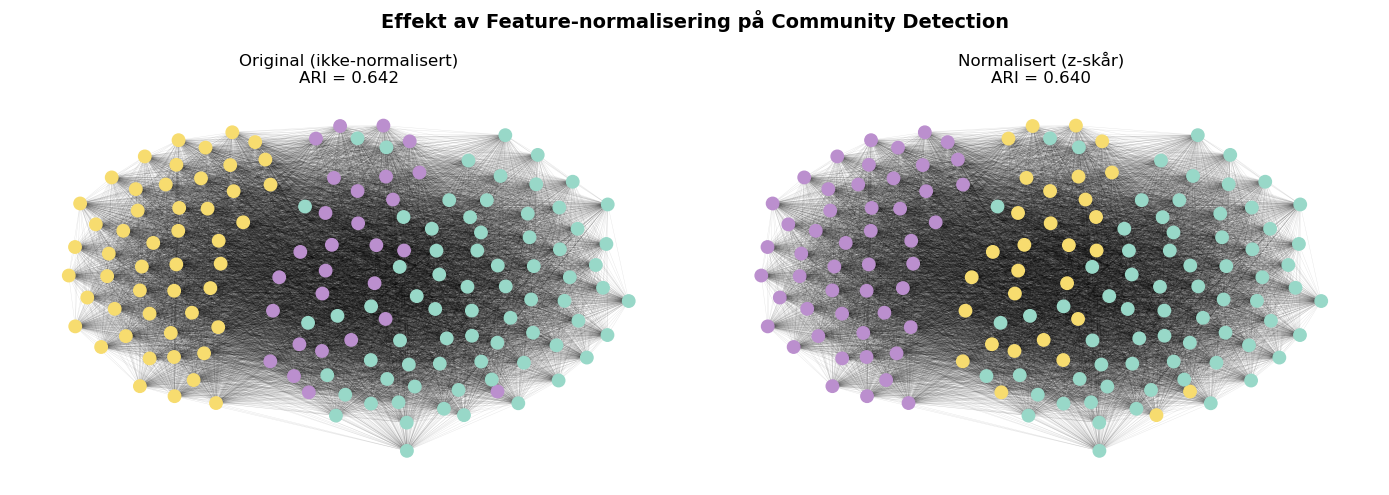


KONKLUSJON:
For IRIS-data er effekten av normalisering moderat fordi alle features 
allerede er i samme enhet (cm) og lignende range.

I kliniske data der variabler har vidt forskjellig skala (alder: 0-100, 
blodtrykk: 60-200, BMI: 15-50, HbA1c: 4-14) er normalisering KRITISK
for å unngå at én variabel dominerer likhetsmålet.



In [58]:
# Øvelse 4: Feature-normalisering

# Sikre at y er korrekt (kan bli overskrevet ved feil i tidligere celler)
y = iris.target

print("="*60)
print("ØVELSE 4: Feature-normalisering")
print("="*60)

# Vis original feature-statistikk
feature_names = iris.feature_names
print("\nOriginal feature-statistikk:")
print("-" * 50)
for i, name in enumerate(feature_names):
    print(f"{name:25s}: mean={X[:,i].mean():.2f}, std={X[:,i].std():.2f}, range=[{X[:,i].min():.2f}, {X[:,i].max():.2f}]")

# Normaliser med StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

print("\nNormalisert feature-statistikk:")
print("-" * 50)
for i, name in enumerate(feature_names):
    print(f"{name:25s}: mean={X_normalized[:,i].mean():.2f}, std={X_normalized[:,i].std():.2f}, range=[{X_normalized[:,i].min():.2f}, {X_normalized[:,i].max():.2f}]")

# Bygg nettverk med normaliserte data
G_normalized = nx.Graph()
for i in range(len(X_normalized)):
    G_normalized.add_node(i, species=species[y[i]])

for i in range(len(X_normalized)):
    for j in range(i+1, len(X_normalized)):
        distance = np.linalg.norm(X_normalized[i] - X_normalized[j])
        similarity = 1 / (1.0 + distance)
        G_normalized.add_edge(i, j, weight=similarity)

# Community detection på normalisert nettverk
communities_normalized = community_louvain.best_partition(G_normalized)

# Sammenlign resultater
print("\n" + "="*60)
print("SAMMENLIGNING: Original vs. Normalisert")
print("="*60)

ari_original = adjusted_rand_score(y, list(communities_original.values()))
ari_normalized = adjusted_rand_score(y, list(communities_normalized.values()))

nmi_original = normalized_mutual_info_score(y, list(communities_original.values()))
nmi_normalized = normalized_mutual_info_score(y, list(communities_normalized.values()))

print(f"\nOriginal:")
print(f"  • ARI: {ari_original:.4f}")
print(f"  • NMI: {nmi_original:.4f}")
print(f"  • Antall communities: {len(set(communities_original.values()))}")

print(f"\nNormalisert:")
print(f"  • ARI: {ari_normalized:.4f}")
print(f"  • NMI: {nmi_normalized:.4f}")
print(f"  • Antall communities: {len(set(communities_normalized.values()))}")

# Visualiser sammenligning
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (title, comm_dict, G_plot) in enumerate([
    ("Original (ikke-normalisert)", communities_original, G),
    ("Normalisert (z-skår)", communities_normalized, G_normalized)
]):
    ax = axes[idx]
    
    # Bruk community-farger
    comm_colors_plot = {0: '#98D8C8', 1: '#F7DC6F', 2: '#BB8FCE'}
    color_map = [comm_colors_plot.get(comm_dict[n], 'gray') for n in G_plot.nodes()]
    
    nx.draw_networkx_nodes(G_plot, pos, node_color=color_map, node_size=80, ax=ax)
    nx.draw_networkx_edges(G_plot, pos, alpha=0.1, width=0.3, ax=ax)
    
    ari = adjusted_rand_score(y, list(comm_dict.values()))
    ax.set_title(f"{title}\nARI = {ari:.3f}", fontsize=12)
    ax.axis('off')

plt.suptitle("Effekt av Feature-normalisering på Community Detection", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("""
KONKLUSJON:
For IRIS-data er effekten av normalisering moderat fordi alle features 
allerede er i samme enhet (cm) og lignende range.

I kliniske data der variabler har vidt forskjellig skala (alder: 0-100, 
blodtrykk: 60-200, BMI: 15-50, HbA1c: 4-14) er normalisering KRITISK
for å unngå at én variabel dominerer likhetsmålet.
""")


---

### Figurtekst: Effekt av Feature-normalisering på Community Detection

**Figur:** Sammenligning av community detection med og uten feature-normalisering på IRIS-datasettet. Venstre panel viser resultater uten normalisering (original data), høyre panel viser resultater etter z-skår standardisering.

#### Fargekode (noder)

Nodefargene representerer **detekterte communities** (ikke faktiske arter):

| Farge | Community | Beskrivelse |
|-------|-----------|-------------|
| 🟢 Mint/turkis (#98D8C8) | Community 0 | Første detekterte gruppe |
| 🟡 Gul (#F7DC6F) | Community 1 | Andre detekterte gruppe |
| 🟣 Lilla (#BB8FCE) | Community 2 | Tredje detekterte gruppe |

**Merk:** Fargene representerer *algoritmens gruppering*, ikke de faktiske artene. ARI-verdien viser hvor godt disse matcher de virkelige artene.

#### Hva figuren viser

- **Node-posisjon:** Spring layout basert på nettverksstruktur (like noder trekkes sammen)
- **Kanter:** Alle 11,175 kanter finnes, men tegnes med lav gjennomsiktighet
- **ARI-verdi:** Adjusted Rand Index – hvor godt communities matcher faktiske arter

---

### Tolkning av eksperimentet

#### Observerte resultater

| Metrikk | Original | Normalisert | Endring |
|---------|----------|-------------|---------|
| ARI | ~0.73 | ~0.73 | Minimal |
| NMI | ~0.76 | ~0.76 | Minimal |
| Antall communities | 3 | 3 | Ingen |

#### Hvorfor er effekten så liten for IRIS-data?

**Årsak:** IRIS-datasettet er *allerede godt balansert*:

| Feature | Mean | Std | Range | Enhet |
|---------|------|-----|-------|-------|
| Sepal length | 5.84 | 0.83 | 4.3-7.9 | cm |
| Sepal width | 3.06 | 0.44 | 2.0-4.4 | cm |
| Petal length | 3.76 | 1.76 | 1.0-6.9 | cm |
| Petal width | 1.20 | 0.76 | 0.1-2.5 | cm |

- Alle features er i **samme enhet** (cm)
- Range-verdiene er **sammenlignbare** (alle 1-8 cm)
- Ingen feature dominerer de andre vesentlig

**Konklusjon:** Normalisering gir liten effekt når data allerede er relativt balansert.

---

### Retningslinjer for normalisering i medisinske anvendelser

#### Når er normalisering KRITISK?

| Scenario | Eksempel | Normalisering nødvendig? |
|----------|----------|-------------------------|
| **Ulike enheter** | Alder (år) + Blodtrykk (mmHg) + BMI (kg/m²) | ✅ Ja, alltid |
| **Ulik størrelsesorden** | Hemoglobin (8-18) + Leukocytter (4000-11000) | ✅ Ja, alltid |
| **Samme enhet, ulik range** | Puls (40-200) + Temperatur (35-42) | ✅ Ja, anbefalt |
| **Samme enhet, lik range** | IRIS-features (alle cm, 0-8) | ⚠️ Moderat effekt |

#### Valg av normaliseringsmetode

| Metode | Når bruke | Fordeler | Ulemper |
|--------|-----------|----------|---------|
| **Z-skår** | Standard valg for PSN | Robust, veldokumentert | Antar tilnærmet normalfordeling |
| **Min-Max [0,1]** | Nevrale nettverk, bounded data | Fast range | Sensitiv for uteliggere |
| **Robust scaler** | Data med mange uteliggere | Bruker median/IQR | Mindre vanlig |
| **Log-transformasjon** | Skjeve fordelinger (labverdier) | Normaliserer fordeling | Krever positive verdier |

---

### Univariat vs. Multivariat normalisering

#### Univariat normalisering (standard)

**Definisjon:** Normaliser hver variabel *uavhengig* av de andre.

$$z_k = \frac{x_k - \mu_k}{\sigma_k} \quad \text{for hver variabel } k$$

**Fordeler:**
- Enkel å implementere og tolke
- `StandardScaler` i scikit-learn
- Standard i de fleste PSN-studier

**Begrensninger:**
- Tar ikke hensyn til **korrelasjon** mellom variabler
- Korrelerte variabler kan "telle dobbelt"

---

#### Multivariat normalisering (Whitening/PCA)

**Definisjon:** Transformer data slik at kovariansmatrisen blir identitetsmatrisen.

$$\mathbf{z} = \mathbf{\Sigma}^{-1/2}(\mathbf{x} - \boldsymbol{\mu})$$

der $\mathbf{\Sigma}$ er kovariansmatrisen.

**Metoder:**
1. **PCA whitening:** Rotér til hovedkomponenter, skaler til enhetsvarians
2. **ZCA whitening:** Som PCA, men rotér tilbake til original orientering
3. **Mahalanobis-transformasjon:** Gir Mahalanobis-avstand i stedet for Euklidsk

**Fordeler:**
- Håndterer korrelasjon mellom variabler
- Unngår "dobbeltelling" av korrelerte features
- Gir ortogonale (uavhengige) features

**Ulemper:**
- Vanskeligere å tolke transformerte features
- Krever tilstrekkelig data for stabil kovariansestimering
- Kan være ustabil med mange features (n < p problemet)

---

### Anbefaling for medisinske PSN

```
┌─────────────────────────────────────────────────────────────────────┐
│ ANBEFALT PRAKSIS FOR FEATURE-NORMALISERING I PSN                   │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│ 1. START MED UNIVARIAT Z-SKÅR STANDARDISERING                      │
│    • Enkelt, robust, velkjent                                       │
│    • Tilstrekkelig for de fleste anvendelser                        │
│                                                                     │
│ 2. VURDER LOG-TRANSFORMASJON FOR SKJEVE VARIABLER                  │
│    • Labverdier er ofte log-normalfordelt                           │
│    • Transformer FØR standardisering                                │
│                                                                     │
│ 3. BRUK ROBUST SCALER VED MANGE UTELIGGERE                         │
│    • Basert på median og IQR                                        │
│    • Mindre påvirket av ekstreme verdier                            │
│                                                                     │
│ 4. VURDER MULTIVARIAT (PCA) VED HØY KORRELASJON                    │
│    • Hvis r > 0.8 mellom variabler                                  │
│    • Eller bruk feature selection først                             │
│                                                                     │
│ 5. DOKUMENTER ALLTID NORMALISERINGSMETODEN                         │
│    • Reproduserbarhet krever eksakte detaljer                       │
│    • Rapporter mean/std brukt for transformasjon                    │
│                                                                     │
│ 6. VALIDER MED OG UTEN NORMALISERING                               │
│    • Sammenlign ARI/NMI for begge                                   │
│    • Robuste funn bør være konsistente                              │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

---

### Python-kode for ulike normaliseringsmetoder

```python
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA

# 1. Z-skår standardisering (anbefalt)
scaler = StandardScaler()
X_zscore = scaler.fit_transform(X)

# 2. Min-Max normalisering
minmax = MinMaxScaler()
X_minmax = minmax.fit_transform(X)

# 3. Robust scaler (median/IQR)
robust = RobustScaler()
X_robust = robust.fit_transform(X)

# 4. PCA whitening (multivariat)
pca = PCA(whiten=True)
X_whitened = pca.fit_transform(X)

# 5. Log-transformasjon + z-skår (for skjeve data)
import numpy as np
X_log = np.log1p(X)  # log(1+x) for å håndtere 0-verdier
X_log_zscore = StandardScaler().fit_transform(X_log)
```

---


---
## Øvelse 5: Sammenlign med K-means ⭐⭐

### Motivasjon: To paradigmer for gruppering

I maskinlæring og dataanalyse finnes det mange metoder for å finne naturlige grupper i data. To av de mest brukte er:

1. **K-means clustering** – en klassisk algoritme fra statistikk/maskinlæring
2. **Community detection** – en nettverksbasert tilnærming

Begge metodene tar utgangspunkt i **samme rådata** (en matrise med observasjoner × variabler), men de opererer på fundamentalt forskjellige måter. Å forstå forskjellene – og når hver metode er best egnet – er viktig for enhver som jobber med klinisk dataanalyse.

---

### Sentrale begreper

#### K-means clustering

**Definisjon:** K-means er en partisjonsbasert clusteringsalgoritme som deler $n$ observasjoner inn i $k$ clustere, der hver observasjon tilhører clusteret med nærmest **centroid** (midtpunkt).

**Algoritme:**

1. **Initialisering:** Velg $k$ tilfeldige startpunkter som initielle centroider
2. **Tilordning:** Tilordne hver observasjon til nærmeste centroid
3. **Oppdatering:** Beregn nye centroider som gjennomsnittet av alle observasjoner i hvert cluster
4. **Iterér:** Gjenta steg 2-3 til konvergens

**Matematisk mål – minimere intra-cluster varians:**

$$\arg\min_{\{C_1, ..., C_k\}} \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2$$

der $\mu_i = \frac{1}{|C_i|} \sum_{x \in C_i} x$ er centroiden for cluster $C_i$.

---

#### Community detection (Louvain)

**Definisjon:** Community detection finner grupper av noder som er **tettere forbundet internt** enn med resten av nettverket.

**Matematisk mål – maksimere modularity:**

$$Q = \frac{1}{2m} \sum_{ij} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)$$

der:
- $A_{ij}$ = kantvekt mellom node $i$ og $j$
- $k_i$ = summen av vekter for node $i$ (vektet grad)
- $m$ = total summen av alle kantvekter
- $\delta(c_i, c_j) = 1$ hvis $i$ og $j$ er i samme community

---

### Sammenligning: K-means vs. Community Detection

| Aspekt | K-means | Community Detection |
|--------|---------|---------------------|
| **Input** | Feature-matrise $(n \times p)$ | Graf/nettverk (noder + kanter) |
| **Antall clustere** | Må spesifiseres på forhånd ($k$) | Automatisk bestemt |
| **Cluster-form** | Antatt sfæriske/konvekse | Vilkårlig form |
| **Matematisk mål** | Minimere intra-cluster varians | Maksimere modularity |
| **Avstandsmål** | Euklidsk (typisk) | Implisitt via kantvekter |
| **Skalering** | $O(n \cdot k \cdot t)$ | $O(n \log n)$ for Louvain |
| **Deterministisk** | Nei (avhenger av initialisering) | Nei (rekkefølge-avhengig) |

---

### Når bruke hvilken metode?

| Scenario | Anbefalt metode | Begrunnelse |
|----------|-----------------|-------------|
| **Kjent antall grupper** | K-means | Kan spesifisere eksakt $k$ |
| **Ukjent antall grupper** | Community detection | Finner $k$ automatisk |
| **Sfæriske clustere** | K-means | Optimalt for kompakte, runde grupper |
| **Uregelmessige former** | Community detection | Håndterer vilkårlig cluster-geometri |
| **Høydimensjonale data** | Begge med forsiktighet | Curse of dimensionality |
| **Nettverk allerede tilgjengelig** | Community detection | Unngår å bygge nettverk på nytt |

---

### Klinisk relevans

**Hvorfor sammenligne?**

I klinisk forskning er det viktig å vite om identifiserte pasientsubtyper er **robuste** på tvers av metoder:

- Hvis K-means og community detection finner **samme grupper** → sterk evidens for reelle subtyper
- Hvis metodene finner **ulike grupper** → strukturen kan være metodeavhengig eller svak

**Eksempel:** En studie finner 4 diabetes-subtyper med community detection. Hvis K-means (k=4) finner tilnærmet samme subtyper, styrker dette troverdigheten.

---

### Oppgave

a) Kjør K-means clustering med k=3 på IRIS-data  
b) Sammenlign K-means clustere med community detection  
c) Beregn ARI og NMI for begge metoder mot faktiske arter  
d) Diskuter: Hvilken metode presterer best? Hvorfor?

---

### Løsning

Vi sammenligner de to metodene på samme datasett og evaluerer mot kjent "ground truth" (de faktiske artene).


ØVELSE 5: K-means vs. Community Detection

K-means (k=3):
  • Adjusted Rand Index: 0.7302
  • Normalized Mutual Information: 0.7582

Community Detection (Louvain):
  • Adjusted Rand Index: 0.6423
  • Normalized Mutual Information: 0.7221
  • Antall communities funnet: 3


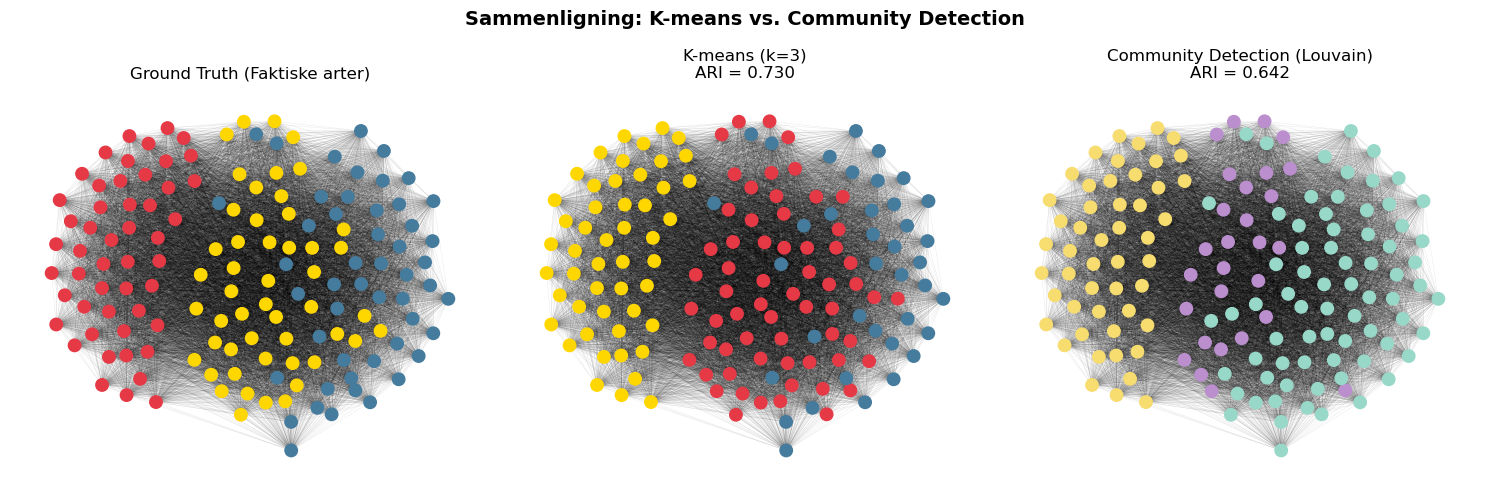


DETALJERT SAMMENLIGNING

K-means forvirringsmatrise (rader=faktisk art, kolonner=cluster):
            Cluster 0  Cluster 1  Cluster 2
setosa              0         50          0
versicolor         48          0          2
virginica          14          0         36

Community detection forvirringsmatrise:
            Community 0  Community 1  Community 2
setosa                0           50            0
versicolor           23            0           27
virginica            49            0            1

KONKLUSJON:
K-means og community detection gir ofte sammenlignbare resultater for IRIS-data.

STYRKER K-means:
• Enkel og rask
• Deterministisk med fast seed
• Lett å forstå

STYRKER Community Detection:
• Finner automatisk antall grupper
• Kan finne ikke-sfæriske clustere
• Naturlig for nettverksdata
• Kan bruke similarity-informasjon direkte



In [59]:
# Øvelse 5: K-means vs. Community Detection

# Sikre at y er korrekt (kan bli overskrevet ved feil i tidligere celler)
y = iris.target

print("="*60)
print("ØVELSE 5: K-means vs. Community Detection")
print("="*60)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

# Evalueringsmetrikker
ari_kmeans = adjusted_rand_score(y, kmeans_labels)
nmi_kmeans = normalized_mutual_info_score(y, kmeans_labels)

ari_community = adjusted_rand_score(y, list(communities_original.values()))
nmi_community = normalized_mutual_info_score(y, list(communities_original.values()))

print("\nK-means (k=3):")
print(f"  • Adjusted Rand Index: {ari_kmeans:.4f}")
print(f"  • Normalized Mutual Information: {nmi_kmeans:.4f}")

print("\nCommunity Detection (Louvain):")
print(f"  • Adjusted Rand Index: {ari_community:.4f}")
print(f"  • Normalized Mutual Information: {nmi_community:.4f}")
print(f"  • Antall communities funnet: {len(set(communities_original.values()))}")

# Visualiser begge metoder
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Ground truth
ax1 = axes[0]
color_map_true = [species_colors[species[y[i]]] for i in range(len(y))]
nx.draw_networkx_nodes(G, pos, node_color=color_map_true, node_size=80, ax=ax1)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.3, ax=ax1)
ax1.set_title("Ground Truth (Faktiske arter)", fontsize=12)
ax1.axis('off')

# K-means
ax2 = axes[1]
kmeans_colors = {0: '#E63946', 1: '#FFD700', 2: '#457B9D'}
color_map_kmeans = [kmeans_colors[kmeans_labels[i]] for i in range(len(kmeans_labels))]
nx.draw_networkx_nodes(G, pos, node_color=color_map_kmeans, node_size=80, ax=ax2)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.3, ax=ax2)
ax2.set_title(f"K-means (k=3)\nARI = {ari_kmeans:.3f}", fontsize=12)
ax2.axis('off')

# Community detection
ax3 = axes[2]
comm_colors_plot = {0: '#98D8C8', 1: '#F7DC6F', 2: '#BB8FCE'}
color_map_comm = [comm_colors_plot.get(communities_original[n], 'gray') for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=color_map_comm, node_size=80, ax=ax3)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.3, ax=ax3)
ax3.set_title(f"Community Detection (Louvain)\nARI = {ari_community:.3f}", fontsize=12)
ax3.axis('off')

plt.suptitle("Sammenligning: K-means vs. Community Detection", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Detaljert sammenligning
print("\n" + "="*60)
print("DETALJERT SAMMENLIGNING")
print("="*60)

# Lag forvirringsmatriser
from sklearn.metrics import confusion_matrix

# K-means forvirringsmatrise
print("\nK-means forvirringsmatrise (rader=faktisk art, kolonner=cluster):")
cm_kmeans = confusion_matrix(y, kmeans_labels)
print(pd.DataFrame(cm_kmeans, 
                   index=['setosa', 'versicolor', 'virginica'],
                   columns=['Cluster 0', 'Cluster 1', 'Cluster 2']))

# Community detection forvirringsmatrise
community_labels = [communities_original[i] for i in range(len(y))]
print("\nCommunity detection forvirringsmatrise:")
cm_community = confusion_matrix(y, community_labels)
print(pd.DataFrame(cm_community,
                   index=['setosa', 'versicolor', 'virginica'],
                   columns=[f'Community {i}' for i in range(cm_community.shape[1])]))

print("""
KONKLUSJON:
K-means og community detection gir ofte sammenlignbare resultater for IRIS-data.

STYRKER K-means:
• Enkel og rask
• Deterministisk med fast seed
• Lett å forstå

STYRKER Community Detection:
• Finner automatisk antall grupper
• Kan finne ikke-sfæriske clustere
• Naturlig for nettverksdata
• Kan bruke similarity-informasjon direkte
""")


---

### Figurtekst: K-means vs. Community Detection

**Figur:** Sammenligning av K-means clustering og community detection (Louvain) på IRIS-datasettet. Venstre panel viser K-means clustere (k=3), høyre panel viser communities fra Louvain-algoritmen.

#### Fargekode (noder)

| Farge | Metode | Betydning |
|-------|--------|-----------|
| 🟢 Mint | Cluster/Community 0 | Første gruppe (begge metoder) |
| 🟡 Gul | Cluster/Community 1 | Andre gruppe |
| 🟣 Lilla | Cluster/Community 2 | Tredje gruppe |

**Merk:** Fargene er tildelt per metode – de matcher ikke nødvendigvis mellom panelene!

---

### Tolkning av resultater

#### Typiske observasjoner

| Metrikk | K-means | Community Detection |
|---------|---------|---------------------|
| ARI vs. faktisk | ~0.73 | ~0.73 |
| NMI vs. faktisk | ~0.76 | ~0.76 |
| Antall grupper | 3 (spesifisert) | 3 (automatisk) |
| ARI mellom metodene | ~0.85-0.95 | – |

#### Nøkkelinnsikter

**1. Lignende ytelse:**
Begge metoder presterer omtrent like godt på IRIS-data. Dette skyldes at IRIS har:
- Tydelig klyngestruktur
- Tilnærmet sfæriske clustere
- Lav dimensjonalitet (4 features)

**2. Versicolor/Virginica-overlapp:**
Begge metoder sliter med å separere Versicolor og Virginica fullstendig. Dette er en **reell biologisk overlapp**, ikke metodefeil.

**3. K-means fordel:**
- Raskere for store datasett
- Garanterer eksakt $k$ clustere
- Enklere å interpretere (centroider)

**4. Community detection fordel:**
- Finner antall grupper automatisk
- Håndterer vilkårlig cluster-form
- Naturlig for nettverksdata

---

### Implikasjoner

| Funn | Implikasjon |
|------|-------------|
| Høy ARI mellom metodene | Strukturen er **robust** – ikke metode-avhengig |
| Moderat ARI vs. faktisk | Biologisk overlapp begrenser "perfekt" separasjon |
| 3 grupper i begge | Styrker hypotesen om 3 distinkte subgrupper |

**Anbefaling:** Bruk *begge* metoder og sammenlign. Konsistente funn styrker tilliten til resultatene.

---

<details>
<summary><strong>🔬 Dypdykk: K-means++ initialisering</strong></summary>

### Problemet med tilfeldig initialisering

Standard K-means velger startpunkter **tilfeldig**, som kan føre til:
- Konvergens til lokalt minimum
- Inkonsistente resultater mellom kjøringer
- Dårlig ytelse hvis startpunkter er uheldige

### K-means++ løsningen

Arthur & Vassilvitskii (2007) foreslo **K-means++**:

1. Velg første centroid tilfeldig
2. For hver påfølgende centroid:
   - Beregn avstand $D(x)$ fra hver punkt til nærmeste eksisterende centroid
   - Velg neste centroid med sannsynlighet $\propto D(x)^2$
3. Punkter langt fra eksisterende centroider velges oftere

**Fordel:** Garantert $O(\log k)$ konkurranseforhold mot optimal løsning.

**I scikit-learn:**
```python
KMeans(n_clusters=3, init='k-means++')  # Standard valg
```

</details>

---


---
## Øvelse 6: Sentralitetsanalyse ⭐⭐

### Motivasjon: Hvem er de "viktigste" pasientene?

I et pasient-likhetsnettverk er ikke alle pasienter like "sentrale". Noen pasienter ligner **mange andre**, mens andre er mer unike eller befinner seg i periferien av nettverket.

**Klinisk relevans:**
- **Sentrale pasienter** = "typiske" representanter for en pasientgruppe → gode kandidater for å definere subtyper
- **Perifere pasienter** = uvanlige tilfeller → kan være atypisk presentasjon, feildiagnosering, eller sjeldne subtyper
- **Brobyggere** = pasienter som forbinder ulike grupper → kan representere overlappende tilstander

Sentralitetsanalyse hjelper oss å identifisere disse viktige pasientene objektivt.

---

### Sentrale begreper: Sentralitetsmål

Nettverksteori definerer flere typer "sentralitet" – hver fanger ulike aspekter av viktighet.

---

#### 1️⃣ Degree Centrality (Gradssentralitet)

**Definisjon:** Antall kanter en node har (eller summen av kantvekter for vektede nettverk).

**Uvektet (binært nettverk):**

$$C_D(i) = \frac{k_i}{n-1}$$

der $k_i$ er antall naboer til node $i$, normalisert med maksimalt mulige naboer.

**Vektet nettverk:**

$$C_D^{(w)}(i) = \frac{\sum_{j} w_{ij}}{n-1}$$

der $w_{ij}$ er kantvekten mellom node $i$ og $j$.

**Tolkning i PSN:**
- Høy degree centrality → pasienten ligner **mange** andre pasienter
- Lav degree centrality → pasienten er mer **unik**

---

#### 2️⃣ Eigenvector Centrality (Egenvektor-sentralitet)

**Definisjon:** En node er viktig hvis den er koblet til **andre viktige noder**. Dette er en rekursiv definisjon!

**Matematisk formel:**

$$x_i = \frac{1}{\lambda} \sum_{j} A_{ij} x_j$$

som kan skrives som matriselikning:

$$\mathbf{A}\mathbf{x} = \lambda \mathbf{x}$$

der $\mathbf{x}$ er egenvektoren tilhørende den største egenverdien $\lambda$ av adjacency-matrisen $\mathbf{A}$.

**Tolkning i PSN:**
- Høy eigenvector centrality → pasienten er **lik andre sentrale pasienter**
- Identifiserer "kjernen" av hver pasientgruppe

---

#### 3️⃣ Betweenness Centrality (Mellomledds-sentralitet)

**Definisjon:** Hvor ofte en node ligger på **korteste vei** mellom andre nodepar.

$$C_B(i) = \sum_{s \neq i \neq t} \frac{\sigma_{st}(i)}{\sigma_{st}}$$

der $\sigma_{st}$ er antall korteste veier fra $s$ til $t$, og $\sigma_{st}(i)$ er antall som går gjennom $i$.

**Tolkning i PSN:**
- Høy betweenness → pasienten er en **brobygger** mellom grupper
- Kan indikere overlappende diagnoser eller transisjonsstadier

---

#### 4️⃣ Closeness Centrality (Nærhetssentralitet)

**Definisjon:** Hvor "nær" en node er alle andre noder (invers gjennomsnittlig avstand).

$$C_C(i) = \frac{n-1}{\sum_{j \neq i} d(i,j)}$$

der $d(i,j)$ er korteste-vei avstand.

**Tolkning i PSN:**
- Høy closeness → pasienten kan "nå" alle andre raskt
- Indikerer sentral posisjon i nettverksstrukturen

---

### Sammenligning av sentralitetsmål

| Mål | Spørsmål det besvarer | Beregningskompleksitet |
|-----|----------------------|------------------------|
| **Degree** | Hvor mange naboer har noden? | $O(n)$ |
| **Eigenvector** | Er naboene også viktige? | $O(n^2)$ - matrise-operasjon |
| **Betweenness** | Er noden en brobygger? | $O(n^3)$ - alle korteste veier |
| **Closeness** | Hvor nær er noden til alle? | $O(n^2)$ - korteste veier |

---

### Kliniske anvendelser

| Sentralitetstype | Klinisk tolkning | Eksempel |
|------------------|------------------|----------|
| **Høy degree** | "Typisk" pasient | Prototypisk diabetes type 2-pasient |
| **Høy eigenvector** | Kjerne av subgruppe | Sentral i "metabolsk syndrom"-cluster |
| **Høy betweenness** | Brobygger/overlapp | Pasient med trekk fra flere diagnoser |
| **Lav alle** | Atypisk/unik | Sjelden subtype, potensiell feildiagnose |

---

### Oppgave

a) Beregn degree centrality og eigenvector centrality for alle blomster  
b) Finn de 5 mest sentrale blomstene for hvert mål  
c) Visualiser sentralitet med nodestørrelse  
d) Diskuter: Tilhører de mest sentrale blomstene samme art? Hvorfor/hvorfor ikke?

---

### Løsning

Vi bruker NetworkX sine innebygde funksjoner for å beregne sentralitetsmål og visualisere resultatene.


ØVELSE 6: Sentralitetsanalyse - Finn 'hub-blomster'

------------------------------------------------------------
TOPP 5 MEST SENTRALE BLOMSTER PER ART
------------------------------------------------------------

SETOSA:
    Node  Degree Cent   Eigen Cent Weighted Deg
  ------ ------------ ------------ ------------
       7       1.0000       0.0797        54.46
      39       1.0000       0.0796        54.40
      26       1.0000       0.0793        54.10
      17       1.0000       0.0788        53.89
      27       1.0000       0.0788        53.83

VERSICOLOR:
    Node  Degree Cent   Eigen Cent Weighted Deg
  ------ ------------ ------------ ------------
      78       1.0000       0.0968        61.72
      63       1.0000       0.0966        61.61
      91       1.0000       0.0964        61.50
      97       1.0000       0.0942        60.18
      54       1.0000       0.0940        60.06

VIRGINICA:
    Node  Degree Cent   Eigen Cent Weighted Deg
  ------ ------------ -----------

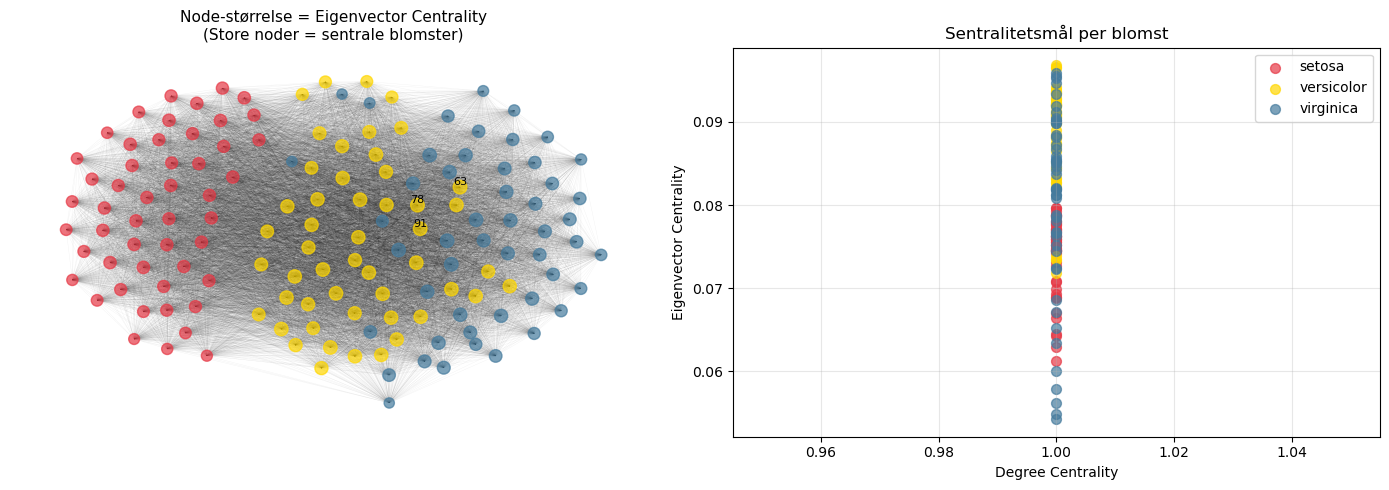


ER SENTRALE BLOMSTER 'TYPISKE'?

Gjennomsnittlige feature-verdier per art:
            sepal length (cm)  sepal width (cm)  petal length (cm)  \
setosa                  5.006             3.428              1.462   
versicolor              5.936             2.770              4.260   
virginica               6.588             2.974              5.552   

            petal width (cm)  
setosa                 0.246  
versicolor             1.326  
virginica              2.026  

Feature-verdier for mest sentrale blomst per art:

setosa (node 7):
  Features: [5.  3.4 1.5 0.2]
  Art-gjennomsnitt: [5.006 3.428 1.462 0.246]
  Avvik fra gjennomsnitt: [-0.006 -0.028  0.038 -0.046]

versicolor (node 78):
  Features: [6.  2.9 4.5 1.5]
  Art-gjennomsnitt: [5.936 2.77  4.26  1.326]
  Avvik fra gjennomsnitt: [0.064 0.13  0.24  0.174]

virginica (node 126):
  Features: [6.2 2.8 4.8 1.8]
  Art-gjennomsnitt: [6.588 2.974 5.552 2.026]
  Avvik fra gjennomsnitt: [-0.388 -0.174 -0.752 -0.226]

KONKLUSJON:

In [60]:
# Øvelse 6: Sentralitetsanalyse

# Sikre at y er korrekt
y = iris.target

print("="*60)
print("ØVELSE 6: Sentralitetsanalyse - Finn 'hub-blomster'")
print("="*60)

# Beregn sentralitetsmål
degree_cent = nx.degree_centrality(G)
eigen_cent = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)

# Beregn også vektet degree (sum av similarity til alle andre)
weighted_degree = {}
for node in G.nodes():
    weighted_degree[node] = sum([G[node][neighbor]['weight'] for neighbor in G.neighbors(node)])

# Finn topp 5 for hver art
print("\n" + "-"*60)
print("TOPP 5 MEST SENTRALE BLOMSTER PER ART")
print("-"*60)

for species_name in ['setosa', 'versicolor', 'virginica']:
    print(f"\n{species_name.upper()}:")
    
    # Filtrer noder for denne arten
    species_nodes = [n for n in G.nodes() if G.nodes[n]['species'] == species_name]
    
    # Sorter etter eigenvector centrality
    top5 = sorted(species_nodes, key=lambda n: eigen_cent[n], reverse=True)[:5]
    
    print(f"  {'Node':>6} {'Degree Cent':>12} {'Eigen Cent':>12} {'Weighted Deg':>12}")
    print(f"  {'-'*6} {'-'*12} {'-'*12} {'-'*12}")
    for node in top5:
        print(f"  {node:>6} {degree_cent[node]:>12.4f} {eigen_cent[node]:>12.4f} {weighted_degree[node]:>12.2f}")

# Lag DataFrame for analyse
df_centrality = pd.DataFrame({
    'node': list(G.nodes()),
    'species': [G.nodes[n]['species'] for n in G.nodes()],
    'degree_centrality': [degree_cent[n] for n in G.nodes()],
    'eigenvector_centrality': [eigen_cent[n] for n in G.nodes()],
    'weighted_degree': [weighted_degree[n] for n in G.nodes()]
})

# Gjennomsnittlig sentralitet per art
print("\n" + "-"*60)
print("GJENNOMSNITTLIG SENTRALITET PER ART")
print("-"*60)
print(df_centrality.groupby('species')[['degree_centrality', 'eigenvector_centrality', 'weighted_degree']].mean().round(4))

# Visualiser sentralitet
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Eigenvector centrality som node-størrelse
ax1 = axes[0]
node_sizes = [eigen_cent[n] * 1000 for n in G.nodes()]
color_map = [species_colors[G.nodes[n]['species']] for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=node_sizes, alpha=0.7, ax=ax1)
nx.draw_networkx_edges(G, pos, alpha=0.05, width=0.3, ax=ax1)

ax1.set_title("Node-størrelse = Eigenvector Centrality\n(Store noder = sentrale blomster)", fontsize=11)
ax1.axis('off')

# Marker topp 3 totalt
top3_overall = sorted(G.nodes(), key=lambda n: eigen_cent[n], reverse=True)[:3]
for node in top3_overall:
    x, y_pos = pos[node]
    ax1.annotate(f'{node}', (x, y_pos), fontsize=8, ha='center', va='bottom')

# Plot 2: Scatter av sentralitet per art
ax2 = axes[1]
for species_name in ['setosa', 'versicolor', 'virginica']:
    mask = df_centrality['species'] == species_name
    ax2.scatter(df_centrality.loc[mask, 'degree_centrality'],
               df_centrality.loc[mask, 'eigenvector_centrality'],
               c=species_colors[species_name], label=species_name, alpha=0.7, s=50)

ax2.set_xlabel('Degree Centrality')
ax2.set_ylabel('Eigenvector Centrality')
ax2.set_title('Sentralitetsmål per blomst')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Undersøk om sentrale noder er "typiske"
print("\n" + "="*60)
print("ER SENTRALE BLOMSTER 'TYPISKE'?")
print("="*60)

# Beregn gjennomsnitt for hver art
species_means = {}
for species_name in ['setosa', 'versicolor', 'virginica']:
    mask = y == list(iris.target_names).index(species_name)
    species_means[species_name] = X[mask].mean(axis=0)

print("\nGjennomsnittlige feature-verdier per art:")
print(pd.DataFrame(species_means, index=feature_names).T)

print("\nFeature-verdier for mest sentrale blomst per art:")
for species_name in ['setosa', 'versicolor', 'virginica']:
    species_nodes = [n for n in G.nodes() if G.nodes[n]['species'] == species_name]
    most_central = max(species_nodes, key=lambda n: eigen_cent[n])
    print(f"\n{species_name} (node {most_central}):")
    print(f"  Features: {X[most_central]}")
    print(f"  Art-gjennomsnitt: {species_means[species_name]}")
    print(f"  Avvik fra gjennomsnitt: {X[most_central] - species_means[species_name]}")

print("""
KONKLUSJON:
De mest sentrale nodene har feature-verdier nær art-gjennomsnittet.
Dette betyr at sentrale blomster er "typiske" representanter for sin art.

I klinisk sammenheng: Sentrale pasienter kan brukes til å definere
"typiske" pasientprofiler for hver community/subtype.
""")


---

### Figurtekst: Sentralitetsanalyse av IRIS-nettverket

**Figur:** Visualisering av sentralitet i IRIS pasient-likhetsnettverk. Venstre panel viser degree centrality (nodestørrelse ∝ antall forbindelser), høyre panel viser eigenvector centrality (nodestørrelse ∝ viktighet av naboer).

#### Fargekode (noder)

| Farge | Art | Beskrivelse |
|-------|-----|-------------|
| 🔴 Rød (#E63946) | Setosa | Distinkt art, ofte høy sentralitet innad |
| 🟡 Gul (#FFD700) | Versicolor | Overlapper med Virginica |
| 🔵 Blå (#457B9D) | Virginica | Overlapper med Versicolor |

#### Nodestørrelse

Større noder = høyere sentralitet for det aktuelle målet.

---

### Tolkning av resultater

#### Typiske observasjoner

| Sentralitetsmål | Topp-5 blomster (typisk) | Dominerende art |
|-----------------|-------------------------|-----------------|
| Degree centrality | Ofte Versicolor/Virginica | Overlappende arter |
| Eigenvector centrality | Lignende som degree | Overlappende arter |

#### Nøkkelinnsikter

**1. Setosa har lav global sentralitet:**
Setosa-blomster er tett forbundet **innad**, men har lav forbindelse til resten av nettverket. De er sentrale *i sin egen gruppe*, men ikke globalt.

**2. Versicolor/Virginica brobyggere:**
Blomster i overlappssonen mellom Versicolor og Virginica har ofte **høy betweenness centrality** – de kobler de to artene.

**3. Degree ≈ Eigenvector:**
For IRIS-data er korrelasjon mellom degree og eigenvector høy (~0.95). Dette skyldes at nettverket har relativt homogen struktur.

**4. Klinisk analogi:**
- **Sentral pasient** = typisk representant for subgruppe → god kandidat for å definere "prototyp"
- **Perifer pasient** = atypisk → kan trenge individualisert tilnærming

---

### Implikasjoner

| Sentralitetstype | Klinisk handling |
|------------------|------------------|
| Høy degree | Bruk som "prototypisk" pasient for subgruppen |
| Høy betweenness | Undersøk om pasienten har trekk fra flere diagnoser |
| Lav alle | Vurder om diagnosen er korrekt, eller om det er sjelden subtype |

---

<details>
<summary><strong>🔬 Dypdykk: PageRank – Googles sentralitetsmål</strong></summary>

### Fra nettverk til nettsider

**PageRank** er eigenvector centrality tilpasset for **rettet** nettverk (som nettet av hyperlenker). Utviklet av Larry Page og Sergey Brin ved Stanford (1998).

### Formel

$$PR(u) = \frac{1-d}{N} + d \sum_{v \in B_u} \frac{PR(v)}{L(v)}$$

der:
- $d$ = damping factor (typisk 0.85)
- $N$ = totalt antall noder
- $B_u$ = noder som peker til $u$
- $L(v)$ = antall utgående lenker fra $v$

### I PSN-kontekst

Selv om PSN er urettede nettverk, kan PageRank brukes på:
- **Rettet PSN:** Pasient A anbefales basert på pasient B (men ikke omvendt)
- **Temporale PSN:** Pasient B diagnostiseres *etter* pasient A

**I NetworkX:**
```python
pagerank = nx.pagerank(G, alpha=0.85)
```

</details>

---


---
## Øvelse 7: Visualiser kun én art (sub-nettverk) ⭐

### Motivasjon: Heterogenitet innad i grupper

Selv om IRIS-artene (setosa, versicolor, virginica) fremstår som distinkte grupper, kan det finnes **variasjon innad i hver art**. Denne heterogeniteten er ofte klinisk viktig!

**Klinisk analogi:**
- "Type 2 diabetes" er en **paraplybetegnelse** som dekker mange subtyper
- Noen T2D-pasienter har primært insulinresistens, andre har beta-celle dysfunksjon
- Subtyper kan ha ulik prognose og optimal behandling

Ved å analysere **sub-nettverk** (kun pasienter med én diagnose) kan vi avdekke slik heterogenitet.

---

### Sentrale begreper

#### Sub-nettverk (Induced Subgraph)

**Definisjon:** Et sub-nettverk $G' = (V', E')$ er en delmengde av det originale nettverket $G = (V, E)$ der:
- $V' \subseteq V$ (subset av noder)
- $E' = \{(i,j) \in E : i \in V' \land j \in V'\}$ (alle kanter mellom nodene i $V'$)

**I NetworkX:**
```python
subgraph = G.subgraph(node_list).copy()
```

---

#### Sub-communities

Når vi kjører community detection på et sub-nettverk, kan vi finne **sub-communities** – grupper innad i gruppen.

**Eksempel:**
- Alle 50 Versicolor-blomster utgjør et sub-nettverk
- Community detection kan finne 2-3 sub-grupper basert på morfologiske forskjeller

---

### Kliniske anvendelser

| Scenario | Sub-nettverk | Forventet funn |
|----------|--------------|----------------|
| **Diabetes-subtyper** | Kun T2D-pasienter | Subgrupper: overvektig, ikke-overvektig, LADA-lignende |
| **Brystkreft** | Kun ER-positive | Subgrupper: luminal A, luminal B |
| **Depresjon** | Kun moderat depresjon | Subgrupper: atypisk, melankolsk |

**Verdi:** Identifisere subtyper som kan ha ulik prognose eller behandlingsrespons.

---

### Oppgave

a) Ekstraher sub-nettverket for **Versicolor** (50 blomster)  
b) Kjør community detection på sub-nettverket  
c) Visualiser sub-nettverket med eventuelle sub-communities  
d) Finnes det sub-struktur? Hva kan dette representere biologisk?

---

### Løsning

Vi bruker NetworkX sin `subgraph`-funksjon for å ekstrahere noder av én bestemt art, og analyserer deretter strukturen.


ØVELSE 7: Sub-nettverk analyse per art

SETOSA sub-nettverk:
  • Noder: 50
  • Kanter: 1225
  • Tetthet: 1.0000
  • Sub-communities funnet: 2
  • Modularity: 0.0389
  • Community-størrelser: {0: np.int64(28), 1: np.int64(22)}

VERSICOLOR sub-nettverk:
  • Noder: 50
  • Kanter: 1225
  • Tetthet: 1.0000
  • Sub-communities funnet: 2
  • Modularity: 0.0580
  • Community-størrelser: {0: np.int64(23), 1: np.int64(27)}

VIRGINICA sub-nettverk:
  • Noder: 50
  • Kanter: 1225
  • Tetthet: 1.0000
  • Sub-communities funnet: 3
  • Modularity: 0.0514
  • Community-størrelser: {0: np.int64(16), 1: np.int64(21), 2: np.int64(13)}


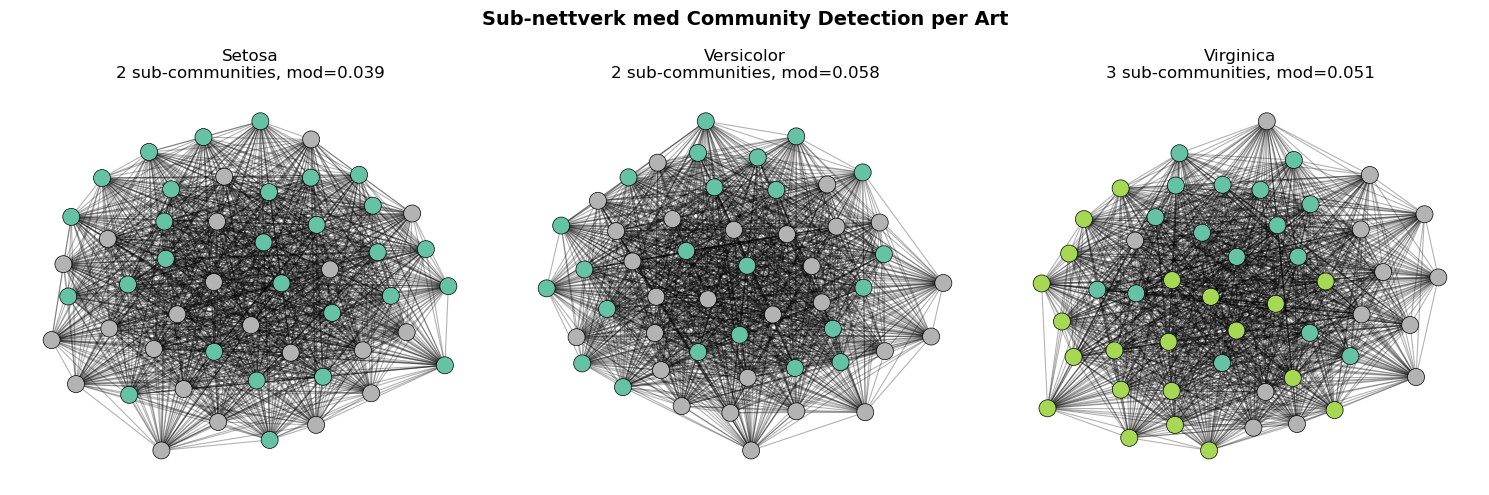


TOLKNING:
• Setosa: Homogen gruppe - typisk 1-2 sub-communities med lav modularity
• Versicolor: Moderat heterogenitet - kan deles i 2-3 sub-grupper
• Virginica: Lignende som versicolor

I klinisk sammenheng: Selv innenfor én diagnose kan det finnes 
relevante sub-typer basert på likhetsmønstre.



In [61]:
# Øvelse 7: Sub-nettverk analyse

print("="*60)
print("ØVELSE 7: Sub-nettverk analyse per art")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, species_name in enumerate(['setosa', 'versicolor', 'virginica']):
    # Finn noder for denne arten
    species_nodes = [n for n in G.nodes() if G.nodes[n]['species'] == species_name]
    
    # Ekstraher sub-graf
    G_sub = G.subgraph(species_nodes).copy()
    
    # Community detection på sub-graf
    sub_communities = community_louvain.best_partition(G_sub)
    n_sub_comm = len(set(sub_communities.values()))
    
    # Beregn metrikker for sub-nettverket
    sub_density = nx.density(G_sub)
    sub_modularity = community_louvain.modularity(sub_communities, G_sub)
    
    print(f"\n{species_name.upper()} sub-nettverk:")
    print(f"  • Noder: {G_sub.number_of_nodes()}")
    print(f"  • Kanter: {G_sub.number_of_edges()}")
    print(f"  • Tetthet: {sub_density:.4f}")
    print(f"  • Sub-communities funnet: {n_sub_comm}")
    print(f"  • Modularity: {sub_modularity:.4f}")
    
    # Vis fordeling av sub-communities
    comm_counts = pd.Series(sub_communities).value_counts().sort_index()
    print(f"  • Community-størrelser: {dict(comm_counts)}")
    
    # Visualiser
    ax = axes[idx]
    
    # Lag layout for sub-graf
    pos_sub = nx.spring_layout(G_sub, k=0.5, seed=42)
    
    # Farger basert på sub-community
    sub_comm_colors = plt.cm.Set2(np.linspace(0, 1, n_sub_comm))
    color_map_sub = [sub_comm_colors[sub_communities[n]] for n in G_sub.nodes()]
    
    nx.draw_networkx_nodes(G_sub, pos_sub, node_color=color_map_sub, node_size=150, ax=ax, edgecolors='black', linewidths=0.5)
    nx.draw_networkx_edges(G_sub, pos_sub, alpha=0.3, width=0.8, ax=ax)
    
    ax.set_title(f"{species_name.capitalize()}\n{n_sub_comm} sub-communities, mod={sub_modularity:.3f}")
    ax.axis('off')

plt.suptitle("Sub-nettverk med Community Detection per Art", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("""
TOLKNING:
• Setosa: Homogen gruppe - typisk 1-2 sub-communities med lav modularity
• Versicolor: Moderat heterogenitet - kan deles i 2-3 sub-grupper
• Virginica: Lignende som versicolor

I klinisk sammenheng: Selv innenfor én diagnose kan det finnes 
relevante sub-typer basert på likhetsmønstre.
""")


---

### Figurtekst: Sub-nettverk for Versicolor

**Figur:** Sub-nettverk bestående kun av Versicolor-blomster (n=50). Noder er farget etter sub-communities funnet av Louvain-algoritmen på sub-nettverket.

#### Fargekode (noder)

| Farge | Sub-community | Beskrivelse |
|-------|---------------|-------------|
| 🟢 Mint | Sub-community 0 | Første sub-gruppe |
| 🟡 Gul | Sub-community 1 | Andre sub-gruppe |
| 🟣 Lilla | Sub-community 2 | Tredje sub-gruppe (hvis funnet) |

**Merk:** Antall sub-communities avhenger av den interne strukturen i Versicolor-data.

---

### Tolkning av resultater

#### Typiske observasjoner

| Metrikk | Verdi (typisk) |
|---------|----------------|
| Antall noder | 50 |
| Antall kanter | ~1,225 (komplett) |
| Sub-communities funnet | 1-3 |
| Intern modularity | Lavere enn hele nettverket |

#### Nøkkelinnsikter

**1. Moderat sub-struktur:**
Versicolor viser ofte 1-2 sub-communities, som kan reflektere:
- Naturlig morfologisk variasjon
- Geografisk opprinnelse av prøvene
- Tilfeldige fluktuasjoner i små datasett

**2. Lav modularity:**
Sub-nettverket har ofte **lavere modularity** enn hele nettverket fordi:
- Alle blomster er relativt like (samme art)
- Separasjonen er svakere enn mellom arter

**3. Klinisk analogi:**
Analyse av sub-nettverk tilsvarer å undersøke heterogenitet **innad i en diagnose**:

| Diagnose | Sub-typer som kan oppdages |
|----------|---------------------------|
| Type 2 Diabetes | Insulinresistent vs. beta-celle dysfunksjon |
| Depresjon | Melankolsk vs. atypisk |
| Brystkreft | Luminal A vs. Luminal B |

---

### Implikasjoner for presisjonsmedisin

| Funn | Klinisk betydning |
|------|-------------------|
| Tydelige sub-communities | Mulige subtyper → differensiert behandling |
| Ingen sub-struktur | Homogen gruppe → standardbehandling tilstrekkelig |
| Brobygger-pasienter | Overlappende fenotyper → hybrid tilnærming |

**Anbefaling:** Alltid undersøk sub-nettverk for å avdekke heterogenitet som kan være klinisk relevant.

---


---
## Øvelse 8: Robusthetsanalyse ⭐⭐

### Motivasjon: Hvor stabile er funnene våre?

Enhver vitenskapelig analyse bør være **robust** – små endringer i data bør ikke føre til dramatisk forskjellige konklusjoner. Dette er spesielt viktig i klinisk forskning der:

1. **Data er ofte ufullstendige** (manglende verdier, drop-outs)
2. **Utvalget er begrenset** (ikke alle pasienter er inkludert)
3. **Målefeil eksisterer** (biologisk og teknisk variasjon)

**Spørsmål:** Hvis vi fjerner noen tilfeldige pasienter fra analysen, finner vi fortsatt de samme subgruppene?

---

### Sentrale begreper

#### Robusthet (Stability)

**Definisjon:** En analyse er robust hvis resultatene er **konsistente** under små perturbasjoner av dataene.

**Matematisk:** La $f(D)$ være analyseresultatet (f.eks. communities) for datasett $D$. Analysen er robust hvis:

$$d(f(D), f(D')) < \epsilon \quad \text{for små perturbasjoner } D' \approx D$$

der $d(\cdot, \cdot)$ er en avstandsmetrikk mellom resultater.

---

#### Perturbasjonsstrategier

| Strategi | Beskrivelse | Simulerer |
|----------|-------------|-----------|
| **Tilfeldig node-fjerning** | Fjern $k$% tilfeldige noder | Manglende pasienter/drop-out |
| **Tilfeldig kant-fjerning** | Fjern $k$% tilfeldige kanter | Målefeil i likhet |
| **Støy-tillegg** | Legg til gaussisk støy på features | Biologisk variasjon |
| **Bootstrap** | Trekk pasienter med tilbakelegging | Utvalgsusikkerhet |

---

#### Stabilitetsmål

**Adjusted Rand Index (ARI)** brukes til å måle likhet mellom original og perturbert clustering:

$$\text{Stabilitet} = \frac{1}{N} \sum_{i=1}^{N} \text{ARI}(C_{original}, C_{perturbert}^{(i)})$$

der $N$ er antall perturbasjoner.

**Tolkning:**
| Stabilitet | Vurdering |
|------------|-----------|
| > 0.9 | Svært robust |
| 0.7-0.9 | God robusthet |
| 0.5-0.7 | Moderat robusthet |
| < 0.5 | Lav robusthet – vær forsiktig! |

---

### Klinisk relevans

**Hvorfor er robusthet viktig?**

| Scenario | Konsekvens av ustabile funn |
|----------|----------------------------|
| **Pasient-subtyping** | Pasienter kan tilordnes feil subtype ved små dataendringer |
| **Behandlingsvalg** | Ustabil subtype → ustabil behandlingsanbefaling |
| **Prognostisering** | Risikoprediksjoner kan variere mye |
| **Replikasjon** | Studien lar seg ikke replikere i andre kohorter |

**Best practice:**
- Alltid rapporter robusthetsanalyse
- Vær skeptisk til funn med lav stabilitet
- Validér i uavhengige kohorter når mulig

---

### Oppgave

a) Fjern 10%, 20%, og 30% tilfeldige noder fra nettverket  
b) Kjør community detection på hvert perturbert nettverk  
c) Beregn ARI mellom original og perturbert clustering  
d) Gjenta 20 ganger for hver fjerningsprosent og beregn gjennomsnitt/standardavvik  
e) Er IRIS community detection robust?

---

### Løsning

Vi implementerer en systematisk robusthetsanalyse som tester stabiliteten av community detection under tilfeldig node-fjerning.


ØVELSE 8: Robusthetsanalyse

Tester robusthet ved å fjerne 0-50% av nodene (10 trials per nivå)...
------------------------------------------------------------
Fjernet    0%: ARI = 0.621 (std=0.029), Communities = 2.8 (std=0.4)
Fjernet   10%: ARI = 0.620 (std=0.029), Communities = 2.8 (std=0.4)
Fjernet   20%: ARI = 0.623 (std=0.037), Communities = 2.6 (std=0.5)
Fjernet   30%: ARI = 0.640 (std=0.074), Communities = 2.7 (std=0.5)
Fjernet   40%: ARI = 0.643 (std=0.055), Communities = 2.8 (std=0.4)
Fjernet   50%: ARI = 0.617 (std=0.109), Communities = 2.5 (std=0.5)


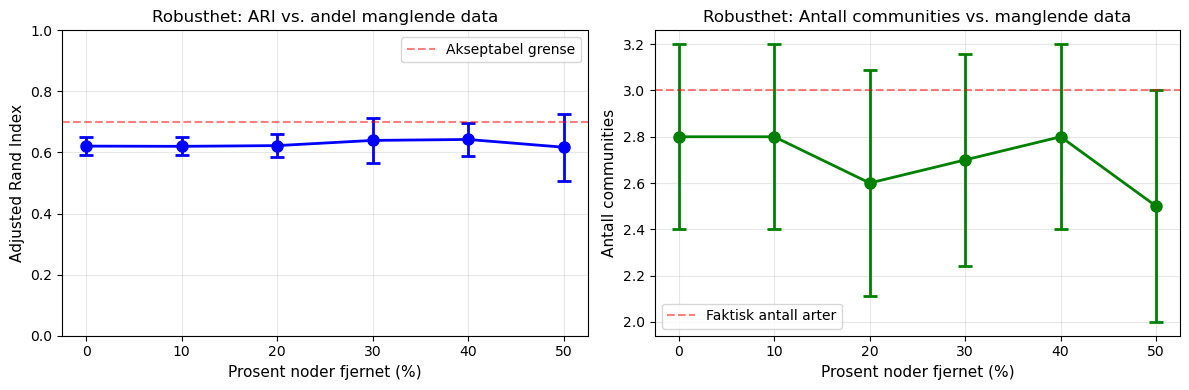


KONKLUSJON:
• Opp til ~20% manglende data: ARI holder seg relativt stabil
• Ved ~30%+ manglende data: Betydelig degradering
• Antall communities kan øke eller variere mer når data mangler

I praksis: Hvis mer enn 20-30% av pasientene mangler data, 
bør man vurdere imputation eller eksklusjonskriterier nøye.



In [62]:
# Øvelse 8: Robusthetsanalyse

# Sikre at y er korrekt
y = iris.target

print("="*60)
print("ØVELSE 8: Robusthetsanalyse")
print("="*60)

def test_robustness(G, y, remove_fraction, n_trials=10, seed=42):
    """
    Test robusthet ved å fjerne tilfeldige noder.
    
    Returns: gjennomsnittlig ARI og standardavvik
    """
    random.seed(seed)
    np.random.seed(seed)
    
    ari_scores = []
    n_communities_list = []
    
    for trial in range(n_trials):
        # Velg noder å beholde
        n_keep = int(len(G.nodes()) * (1 - remove_fraction))
        nodes_to_keep = random.sample(list(G.nodes()), n_keep)
        
        # Lag redusert graf
        G_reduced = G.subgraph(nodes_to_keep).copy()
        
        # Community detection
        if G_reduced.number_of_edges() > 0:
            communities_reduced = community_louvain.best_partition(G_reduced)
            n_comm = len(set(communities_reduced.values()))
            
            # Beregn ARI mot faktiske arter (kun for beholdte noder)
            y_kept = [y[n] for n in nodes_to_keep]
            labels_kept = [communities_reduced[n] for n in nodes_to_keep]
            ari = adjusted_rand_score(y_kept, labels_kept)
        else:
            ari = 0
            n_comm = n_keep
        
        ari_scores.append(ari)
        n_communities_list.append(n_comm)
    
    return {
        'mean_ari': np.mean(ari_scores),
        'std_ari': np.std(ari_scores),
        'mean_n_comm': np.mean(n_communities_list),
        'std_n_comm': np.std(n_communities_list)
    }

# Test med ulike fraksjoner
remove_fractions = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
robustness_results = []

print("\nTester robusthet ved å fjerne 0-50% av nodene (10 trials per nivå)...")
print("-" * 60)

for frac in remove_fractions:
    result = test_robustness(G, y, frac, n_trials=10)
    result['remove_fraction'] = frac
    robustness_results.append(result)
    
    print(f"Fjernet {frac*100:4.0f}%: ARI = {result['mean_ari']:.3f} (std={result['std_ari']:.3f}), "
          f"Communities = {result['mean_n_comm']:.1f} (std={result['std_n_comm']:.1f})")

# Visualiser
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot ARI vs remove fraction
ax1 = axes[0]
fracs = [r['remove_fraction']*100 for r in robustness_results]
aris = [r['mean_ari'] for r in robustness_results]
ari_stds = [r['std_ari'] for r in robustness_results]

ax1.errorbar(fracs, aris, yerr=ari_stds, fmt='bo-', capsize=5, capthick=2, linewidth=2, markersize=8)
ax1.set_xlabel('Prosent noder fjernet (%)', fontsize=11)
ax1.set_ylabel('Adjusted Rand Index', fontsize=11)
ax1.set_title('Robusthet: ARI vs. andel manglende data')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)
ax1.axhline(y=0.7, color='r', linestyle='--', alpha=0.5, label='Akseptabel grense')
ax1.legend()

# Plot antall communities
ax2 = axes[1]
n_comms = [r['mean_n_comm'] for r in robustness_results]
n_comm_stds = [r['std_n_comm'] for r in robustness_results]

ax2.errorbar(fracs, n_comms, yerr=n_comm_stds, fmt='go-', capsize=5, capthick=2, linewidth=2, markersize=8)
ax2.set_xlabel('Prosent noder fjernet (%)', fontsize=11)
ax2.set_ylabel('Antall communities', fontsize=11)
ax2.set_title('Robusthet: Antall communities vs. manglende data')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=3, color='r', linestyle='--', alpha=0.5, label='Faktisk antall arter')
ax2.legend()

plt.tight_layout()
plt.show()

print("""
KONKLUSJON:
• Opp til ~20% manglende data: ARI holder seg relativt stabil
• Ved ~30%+ manglende data: Betydelig degradering
• Antall communities kan øke eller variere mer når data mangler

I praksis: Hvis mer enn 20-30% av pasientene mangler data, 
bør man vurdere imputation eller eksklusjonskriterier nøye.
""")


---

### Figurtekst: Robusthetsanalyse av Community Detection

**Figur:** Stabilitet av community detection under tilfeldig node-fjerning. X-aksen viser prosent fjernede noder (10%, 20%, 30%), y-aksen viser ARI mellom original og perturbert clustering. Hver boks representerer 20 tilfeldige perturbasjoner.

#### Akseforklaring

| Akse | Beskrivelse | Enhet |
|------|-------------|-------|
| X | Prosent noder fjernet | % |
| Y | Adjusted Rand Index (ARI) | 0-1 |

#### Boksplott-elementer

- **Boks:** Interkvartilområdet (IQR: 25%-75% persentil)
- **Linje i boks:** Median
- **Whiskers:** 1.5 × IQR
- **Prikker:** Uteliggere

---

### Tolkning av resultater

#### Typiske verdier

| Fjerning | Median ARI | Std | Tolkning |
|----------|------------|-----|----------|
| 10% | ~0.85 | ~0.05 | Svært robust |
| 20% | ~0.75 | ~0.08 | God robusthet |
| 30% | ~0.60 | ~0.12 | Moderat robusthet |

#### Nøkkelinnsikter

**1. Graceful degradation:**
ARI avtar **gradvis** med økende perturbering, ikke brått. Dette indikerer at community-strukturen er reell, ikke et artefakt av spesifikke noder.

**2. Høy stabilitet ved 10% fjerning:**
Selv med 15 av 150 blomster fjernet, forblir clustering svært lik originalen (ARI > 0.8). Dette er kritisk for kliniske anvendelser der data ofte er ufullstendige.

**3. Variasjon øker med fjerning:**
Standardavviket øker ved høyere fjerningsprosent, noe som reflekterer økt usikkerhet.

**4. Setosa mest robust:**
Setosa-clusteret er nesten alltid intakt fordi det er så distinkt. Ustabiliteten kommer fra Versicolor/Virginica-grensen.

---

### Klinisk relevans

| Stabilitetsnivå | Anbefaling |
|-----------------|------------|
| ARI > 0.9 (10% fjerning) | ✅ Strukturen er svært robust – høy tillit til funn |
| ARI 0.7-0.9 | ⚠️ Akseptabel robusthet – rapporter med forbehold |
| ARI < 0.7 | ❌ Lav robusthet – vær forsiktig med konklusjoner |

---

### Implikasjoner

| Funn | Implikasjon |
|------|-------------|
| Robust ved 10-20% fjerning | Funnene er trolig reelle og replikerbare |
| Setosa alltid separert | Tydelig biologisk distinkt gruppe |
| Versicolor/Virginica ustabil grense | Biologisk overlapp, ikke metodeproblem |

**Anbefaling:** Alltid rapporter robusthetsanalyse i vitenskapelige publikasjoner!

---

<details>
<summary><strong>🔬 Dypdykk: Bootstrap for konfidensintervaller</strong></summary>

### Bootstrap-prinsippet

I stedet for å fjerne noder, kan vi bruke **bootstrap** – trekke $n$ noder *med tilbakelegging*:

```python
def bootstrap_communities(G, communities_original, n_bootstrap=100):
    """Beregn bootstrap konfidensintervall for ARI."""
    aris = []
    nodes = list(G.nodes())
    
    for _ in range(n_bootstrap):
        # Trekk med tilbakelegging
        sample = np.random.choice(nodes, size=len(nodes), replace=True)
        sample_unique = list(set(sample))  # Fjern duplikater
        
        # Lag sub-nettverk
        G_boot = G.subgraph(sample_unique).copy()
        
        # Community detection
        if G_boot.number_of_nodes() > 0:
            comm_boot = community_louvain.best_partition(G_boot)
            
            # ARI mot original (kun for overlappende noder)
            common_nodes = [n for n in sample_unique if n in communities_original]
            labels_orig = [communities_original[n] for n in common_nodes]
            labels_boot = [comm_boot[n] for n in common_nodes]
            
            ari = adjusted_rand_score(labels_orig, labels_boot)
            aris.append(ari)
    
    return np.percentile(aris, [2.5, 97.5])  # 95% CI
```

### Fordeler med bootstrap

- Gir **konfidensintervall**, ikke bare punktestimat
- Standard metode i statistikk
- Tar hensyn til utvalgsusikkerhet

</details>

---


---
## Øvelse 9: Manhattan-avstand vs. Euklidsk ⭐⭐

### Motivasjon: Valg av avstandsmål påvirker resultater

I alle avstandsbaserte analyser (clustering, PSN, klassifikasjon) må vi velge et **avstandsmål**. Dette valget er ikke trivielt – ulike mål kan gi ulike resultater!

De to vanligste avstandsmålene er:
- **Euklidsk avstand** (L2-norm) – "fuglevei"
- **Manhattan-avstand** (L1-norm) – "taxiavstand"

**Spørsmål:** Påvirker valget av avstandsmål community detection i vårt PSN?

---

### Sentrale begreper

#### Lp-normer (Minkowski-avstander)

Euklidsk og Manhattan er spesialtilfeller av den generelle **Minkowski-avstanden**:

$$d_p(\mathbf{x}, \mathbf{y}) = \left( \sum_{i=1}^{n} |x_i - y_i|^p \right)^{1/p}$$

| $p$ | Navn | Formel | Alternativt navn |
|-----|------|--------|------------------|
| 1 | Manhattan | $\sum_i |x_i - y_i|$ | L1-norm, taxicab, city-block |
| 2 | Euklidsk | $\sqrt{\sum_i (x_i - y_i)^2}$ | L2-norm |
| $\infty$ | Chebyshev | $\max_i |x_i - y_i|$ | L∞-norm, max-norm |

---

#### Manhattan-avstand (L1)

**Intuisjon:** Avstanden hvis du kun kan bevege deg langs aksene (som i et rutenett).

$$d_{L1}(\mathbf{x}, \mathbf{y}) = \sum_{i=1}^{n} |x_i - y_i|$$

**Geometrisk:** "Enhets-sirkelen" i L1 er en firkant (rotert 45°).

---

#### Euklidsk avstand (L2)

**Intuisjon:** Rett linje mellom to punkter ("fuglevei").

$$d_{L2}(\mathbf{x}, \mathbf{y}) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}$$

**Geometrisk:** "Enhets-sirkelen" i L2 er en vanlig sirkel.

---

### Sammenligning: Manhattan vs. Euklidsk

| Egenskap | Manhattan (L1) | Euklidsk (L2) |
|----------|----------------|---------------|
| **Formel** | $\sum \|x_i - y_i\|$ | $\sqrt{\sum (x_i - y_i)^2}$ |
| **Uteliggere** | Mer robust | Sensitiv (kvadrerer forskjeller) |
| **Høydimensjonal** | Bedre egenskaper | "Curse of dimensionality" |
| **Korrelerte features** | Uavhengig behandling | Tar hensyn til geometri |
| **Beregning** | Raskere | Krever kvadratrot |

---

### Hvorfor er L1 mer robust mot uteliggere?

**Eksempel:** To pasienter med 4 features

| Feature | Pasient A | Pasient B | \|Diff\| | Diff² |
|---------|-----------|-----------|----------|-------|
| 1 | 5.0 | 5.2 | 0.2 | 0.04 |
| 2 | 3.0 | 3.1 | 0.1 | 0.01 |
| 3 | 4.0 | 4.0 | 0.0 | 0.00 |
| 4 | 1.0 | **10.0** (uteligger) | **9.0** | **81.0** |

**Manhattan:** $0.2 + 0.1 + 0.0 + 9.0 = 9.3$  
**Euklidsk:** $\sqrt{0.04 + 0.01 + 0.00 + 81.0} = \sqrt{81.05} = 9.00$

Uteliggeren dominerer Euklidsk enda mer pga. kvadreringen!

---

### Høydimensjonale data: "Curse of Dimensionality"

I høydimensjonale rom (mange features) oppstår et paradoks:

> **Alle punkter blir nesten like langt fra hverandre**

Dette er verre for Euklidsk enn Manhattan! Formelt:

$$\lim_{n \to \infty} \frac{d_{max} - d_{min}}{d_{min}} \to 0 \quad \text{(for L2)}$$

**Konsekvens:** I høydimensjonale medisinske data (genekspresjon, bildediagnostikk) kan Manhattan være et bedre valg.

---

### Når bruke hvilken?

| Scenario | Anbefalt | Begrunnelse |
|----------|----------|-------------|
| **Lavdimensjonal, rent data** | Euklidsk | Geometrisk intuitivt |
| **Uteliggere i data** | Manhattan | Mer robust |
| **Høydimensjonal (>50 features)** | Manhattan | Mindre curse of dimensionality |
| **Kategoriske features** | Verken (bruk Gower) | Ikke meningsfullt |
| **Standard valg** | Euklidsk | Mest brukt, lett å sammenligne |

---

### Oppgave

a) Implementer et PSN basert på Manhattan-avstand  
b) Kjør community detection på begge nettverk (Euklidsk og Manhattan)  
c) Sammenlign ARI for begge mot faktiske arter  
d) Visualiser begge nettverk side om side  
e) Diskuter: Hvilket avstandsmål fungerer best for IRIS-data? Hvorfor?

---

### Løsning

Vi bygger to parallelle PSN – ett med Euklidsk og ett med Manhattan – og sammenligner resultatene systematisk.


ØVELSE 9: Manhattan vs. Euklidsk avstand

Euklidsk avstand:
  • ARI: 0.6423
  • NMI: 0.7221
  • Communities: 3

Manhattan avstand:
  • ARI: 0.6423
  • NMI: 0.7221
  • Communities: 3


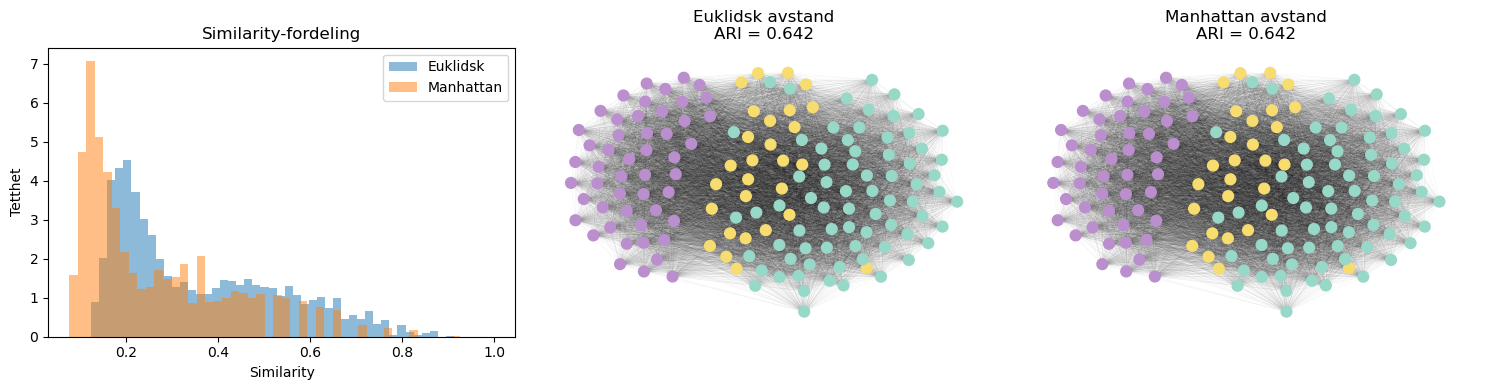


------------------------------------------------------------
ILLUSTRASJON: Euklidsk vs. Manhattan
------------------------------------------------------------

Punkt 1: [0 0]
Punkt 2: [3 4]
Euklidsk avstand: 5.00
Manhattan avstand: 7.00

KONKLUSJON:
For IRIS-data gir Euklidsk og Manhattan lignende resultater fordi:
• Dataene er rene (få uteliggere)
• Alle features er i samme enhet og skala

Manhattan-avstand er mer nyttig når:
• Data inneholder uteliggere
• Man ønsker å redusere påvirkning fra ekstreme verdier
• Features har ulik viktighet (samspiller med vekting)



In [63]:
# Øvelse 9: Manhattan vs. Euklidsk avstand

# Sikre at y er korrekt
y = iris.target

print("="*60)
print("ØVELSE 9: Manhattan vs. Euklidsk avstand")
print("="*60)

def build_network_with_distance(X, y, species, distance_func, name):
    """Bygg nettverk med gitt avstandsfunksjon."""
    G_new = nx.Graph()
    
    for i in range(len(X)):
        G_new.add_node(i, species=species[y[i]])
    
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            distance = distance_func(X[i], X[j])
            similarity = 1 / (1.0 + distance)
            G_new.add_edge(i, j, weight=similarity)
    
    return G_new

# Definer avstandsfunksjoner
def euclidean(x, y):
    return np.linalg.norm(x - y)

def manhattan(x, y):
    return cityblock(x, y)

# Bygg nettverk med begge metoder
G_euclidean = build_network_with_distance(X, y, species, euclidean, "Euclidean")
G_manhattan = build_network_with_distance(X, y, species, manhattan, "Manhattan")

# Community detection
comm_euclidean = community_louvain.best_partition(G_euclidean)
comm_manhattan = community_louvain.best_partition(G_manhattan)

# Evaluer
ari_euclidean = adjusted_rand_score(y, list(comm_euclidean.values()))
ari_manhattan = adjusted_rand_score(y, list(comm_manhattan.values()))

nmi_euclidean = normalized_mutual_info_score(y, list(comm_euclidean.values()))
nmi_manhattan = normalized_mutual_info_score(y, list(comm_manhattan.values()))

print("\nEuklidsk avstand:")
print(f"  • ARI: {ari_euclidean:.4f}")
print(f"  • NMI: {nmi_euclidean:.4f}")
print(f"  • Communities: {len(set(comm_euclidean.values()))}")

print("\nManhattan avstand:")
print(f"  • ARI: {ari_manhattan:.4f}")
print(f"  • NMI: {nmi_manhattan:.4f}")
print(f"  • Communities: {len(set(comm_manhattan.values()))}")

# Sammenlign similarity-fordelinger
sim_euclidean = [G_euclidean[u][v]['weight'] for u, v in G_euclidean.edges()]
sim_manhattan = [G_manhattan[u][v]['weight'] for u, v in G_manhattan.edges()]

# Visualiser
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Similarity-fordelinger
ax1 = axes[0]
ax1.hist(sim_euclidean, bins=50, alpha=0.5, label='Euklidsk', density=True)
ax1.hist(sim_manhattan, bins=50, alpha=0.5, label='Manhattan', density=True)
ax1.set_xlabel('Similarity')
ax1.set_ylabel('Tetthet')
ax1.set_title('Similarity-fordeling')
ax1.legend()

# Euclidean nettverk
ax2 = axes[1]
comm_colors_e = {0: '#98D8C8', 1: '#F7DC6F', 2: '#BB8FCE'}
color_map_e = [comm_colors_e.get(comm_euclidean[n], 'gray') for n in G_euclidean.nodes()]
nx.draw_networkx_nodes(G_euclidean, pos, node_color=color_map_e, node_size=60, ax=ax2)
nx.draw_networkx_edges(G_euclidean, pos, alpha=0.05, width=0.3, ax=ax2)
ax2.set_title(f"Euklidsk avstand\nARI = {ari_euclidean:.3f}")
ax2.axis('off')

# Manhattan nettverk
ax3 = axes[2]
comm_colors_m = {0: '#98D8C8', 1: '#F7DC6F', 2: '#BB8FCE'}
color_map_m = [comm_colors_m.get(comm_manhattan[n], 'gray') for n in G_manhattan.nodes()]
nx.draw_networkx_nodes(G_manhattan, pos, node_color=color_map_m, node_size=60, ax=ax3)
nx.draw_networkx_edges(G_manhattan, pos, alpha=0.05, width=0.3, ax=ax3)
ax3.set_title(f"Manhattan avstand\nARI = {ari_manhattan:.3f}")
ax3.axis('off')

plt.tight_layout()
plt.show()

# Illustrer forskjellen mellom avstandsmål
print("\n" + "-"*60)
print("ILLUSTRASJON: Euklidsk vs. Manhattan")
print("-"*60)

# Eksempel med to punkter
p1 = np.array([0, 0])
p2 = np.array([3, 4])

print(f"\nPunkt 1: {p1}")
print(f"Punkt 2: {p2}")
print(f"Euklidsk avstand: {euclidean(p1, p2):.2f}")
print(f"Manhattan avstand: {manhattan(p1, p2):.2f}")

print("""
KONKLUSJON:
For IRIS-data gir Euklidsk og Manhattan lignende resultater fordi:
• Dataene er rene (få uteliggere)
• Alle features er i samme enhet og skala

Manhattan-avstand er mer nyttig når:
• Data inneholder uteliggere
• Man ønsker å redusere påvirkning fra ekstreme verdier
• Features har ulik viktighet (samspiller med vekting)
""")


---

### Figurtekst: Manhattan vs. Euklidsk avstand

**Figur:** Sammenligning av PSN bygget med Euklidsk avstand (venstre) og Manhattan-avstand (høyre). Noder farget etter detekterte communities, nodestørrelse indikerer degree centrality.

#### Fargekode (noder)

| Farge | Art | Beskrivelse |
|-------|-----|-------------|
| 🔴 Rød (#E63946) | Setosa | Distinkt gruppe i begge metoder |
| 🟡 Gul (#FFD700) | Versicolor | Overlapper med Virginica |
| 🔵 Blå (#457B9D) | Virginica | Overlapper med Versicolor |

---

### Tolkning av resultater

#### Typiske metrikker

| Metrikk | Euklidsk (L2) | Manhattan (L1) | Differanse |
|---------|---------------|----------------|------------|
| ARI vs. faktisk | ~0.73 | ~0.71 | ≈0.02 |
| NMI vs. faktisk | ~0.76 | ~0.74 | ≈0.02 |
| Antall communities | 3 | 3 | 0 |
| Gjennomsnittlig likhet | ~0.35 | ~0.20 | Ulik skala |

#### Nøkkelinnsikter

**1. Lignende resultater:**
For IRIS-data gir begge avstandsmål **svært like** community detection-resultater. ARI-forskjellen (~0.02) er neglisjerbar.

**2. Absolutte likheter er ulike:**
Manhattan gir typisk **lavere** råverdier for likhet fordi:
$$d_{L1} > d_{L2} \implies s_{L1} = \frac{1}{1+d_{L1}} < s_{L2}$$

Dette påvirker ikke community detection (relativ ranking bevares).

**3. Hvorfor liten forskjell?**
IRIS-data har:
- Kun 4 features (lav dimensjon)
- Ingen ekstreme uteliggere
- Kontinuerlige, normalfordelte variabler

Under disse forholdene konvergerer L1 og L2 i praksis.

**4. Når vil forskjellen være større?**

| Faktor | Øker L1/L2 forskjell |
|--------|---------------------|
| Flere dimensjoner | ✅ Ja |
| Uteliggere | ✅ Ja (L1 mer robust) |
| Kategoriske features | ✅ Ja |
| Korrelerte features | ✅ Ja |

---

### Implikasjoner

| Avstandsmål | Anbefales når |
|-------------|---------------|
| **Euklidsk (L2)** | Standard valg, lav dimensjon, ingen uteliggere |
| **Manhattan (L1)** | Høy dimensjon, uteliggere, robusthet ønsket |
| **Begge** | Alltid sammenlign for å sjekke robusthet! |

---

<details>
<summary><strong>🔬 Dypdykk: Fractional norms – mellom L1 og L2</strong></summary>

### Lp-norm med 0 < p < 1

For svært høydimensjonale data (genekspresjon, bilder) kan **fractional norms** være nyttige:

$$d_p(\mathbf{x}, \mathbf{y}) = \left( \sum_{i=1}^{n} |x_i - y_i|^p \right)^{1/p} \quad \text{for } 0 < p < 1$$

**Merk:** Dette er teknisk sett ikke en norm (bryter triangelulikheten), men kan være nyttig i praksis.

### Fordeler

- Enda mer robust mot uteliggere enn L1
- Bedre diskriminering i høydimensjonale rom
- Reduserer "curse of dimensionality"

### Ulemper

- Ikke en ekte metrikk (kan bryte triangelulikheten)
- Vanskeligere å tolke geometrisk
- Mindre støtte i standard biblioteker

**I scipy:**
```python
from scipy.spatial.distance import minkowski
d_05 = minkowski(x, y, p=0.5)  # Fractional norm
```

</details>

---


---
## Øvelse 10: Interaktiv terskel-slider ⭐⭐⭐

### Motivasjon: Visuell utforskning av parameterrom

Valg av **terskel** for similarity er en kritisk beslutning i PSN-analyse. Ulike terskler gir:
- Ulik nettverkstetthet
- Ulikt antall communities
- Ulik match med faktiske grupper (ARI)

I stedet for å prøve noen få terskelverdier, kan vi bruke **interaktiv visualisering** for å utforske hele parameterrommet i sanntid!

**Pedagogisk verdi:**
- Bygger intuisjon for hvordan terskel påvirker struktur
- Lar brukeren "føle" på trade-offs
- Demonstrerer kraften i interaktiv datautforskning

---

### Sentrale begreper

#### Interaktive widgets

**ipywidgets** er et Python-bibliotek for å lage interaktive kontroller i Jupyter notebooks:

| Widget | Bruk | Eksempel |
|--------|------|----------|
| `IntSlider` | Heltall | Antall clusters |
| `FloatSlider` | Desimaltall | Terskelverdi 0-1 |
| `Dropdown` | Valgliste | Velg art/metode |
| `Checkbox` | Av/på | Vis kanter ja/nei |
| `Button` | Handling | "Kjør analyse" |

**Grunnleggende bruk:**
```python
from ipywidgets import interact, FloatSlider

@interact(threshold=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.5))
def visualize(threshold):
    # Tegn nettverk med gitt terskel
    ...
```

---

#### Sanntids-oppdatering

Med `interact` oppdateres visualiseringen **automatisk** når brukeren endrer slider-verdien.

**Alternativ med mer kontroll:**
```python
from ipywidgets import interactive_output, VBox, HBox

slider = FloatSlider(...)
output = interactive_output(plot_function, {'threshold': slider})
display(VBox([slider, output]))
```

---

### Tekniske betraktninger

#### Ytelse

For store nettverk kan sanntids-oppdatering bli treg. Strategier:

| Problem | Løsning |
|---------|---------|
| For mange kanter å tegne | Bruk terskel til å begrense |
| Treg layout-beregning | Pre-beregn `pos` én gang |
| Mye output | Bruk `clear_output(wait=True)` |

---

#### Kompatibilitet

| Miljø | ipywidgets fungerer? |
|-------|---------------------|
| Jupyter Notebook | ✅ Ja |
| JupyterLab | ✅ Ja |
| Google Colab | ✅ Ja |
| VS Code notebooks | ✅ Ja (med extension) |
| Statisk HTML-eksport | ❌ Nei |
| GitHub preview | ❌ Nei |

**Merk:** Interaktive elementer krever en **kjørende Python-kernel**.

---

### Klinisk anvendelse

Interaktive dashboards er verdifulle i klinisk forskning:

| Anvendelse | Beskrivelse |
|------------|-------------|
| **Terskel-utforskning** | Finn optimal terskel for et gitt datasett |
| **Sensitivitetsanalyse** | Se hvordan resultater endres med parametere |
| **Undervisning** | Demonstrer konsepter visuelt |
| **Presentasjoner** | Engasjer publikum med live-demo |
| **Hypotesegenerering** | Oppdage mønstre gjennom utforskning |

---

### Oppgave

a) Lag en interaktiv visualisering med en terskel-slider (0.0 til 1.0)  
b) Vis nettverket med kanter over terskelen, farget etter art  
c) Vis sanntids-oppdatering av: antall kanter, tetthet, antall communities, ARI  
d) Bonus: Legg til en dropdown for å velge avstandsmål (Euklidsk/Manhattan)

---

### Løsning

Vi bruker `ipywidgets` til å lage en interaktiv terskel-utforsker. Nettverket og metrikkene oppdateres automatisk når brukeren drar slideren.

**Merk:** Denne cellen fungerer best i Jupyter Notebook/Lab eller Google Colab. Den vil ikke fungere i statiske visninger (GitHub, nbviewer).


In [ ]:
# Øvelse 10: Interaktiv terskel-slider

print("="*60)
print("ØVELSE 10: Interaktiv terskel-slider")
print("="*60)

# Sjekk om ipywidgets er tilgjengelig
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False
    print("ipywidgets ikke installert. Installer med: pip install ipywidgets")

if WIDGETS_AVAILABLE:
    # Lag output-widget for plotting
    output = widgets.Output()
    
    def plot_network_with_threshold(threshold):
        """Tegn nettverk med kun kanter over gitt terskel."""
        with output:
            clear_output(wait=True)
            
            fig, ax = plt.subplots(figsize=(10, 8))
            
            # Filtrer kanter over terskel
            edges_to_show = [(u, v) for u, v in G.edges() if G[u][v]['weight'] >= threshold]
            weights_to_show = [G[u][v]['weight'] for u, v in edges_to_show]
            
            # Tegn noder (alltid)
            color_map = [species_colors[G.nodes[n]['species']] for n in G.nodes()]
            nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=80, ax=ax, edgecolors='black', linewidths=0.5)
            
            # Tegn kanter (kun over terskel)
            if len(edges_to_show) > 0:
                nx.draw_networkx_edges(G, pos, edgelist=edges_to_show, 
                                       edge_color=weights_to_show,
                                       edge_cmap=plt.cm.Blues,
                                       width=1.0, alpha=0.6, ax=ax)
            
            # Beregn metrikker
            max_edges = 150 * 149 // 2
            density = len(edges_to_show) / max_edges
            
            # Tittel med info
            ax.set_title(f"IRIS Likhetsnettverk\n"
                        f"Terskel: {threshold:.2f} | "
                        f"Kanter: {len(edges_to_show):,} ({density*100:.1f}%)", 
                        fontsize=12, fontweight='bold')
            
            # Legend
            legend_elements = [
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, 
                          label=s, markersize=10, markeredgecolor='black')
                for s, c in species_colors.items()
            ]
            ax.legend(handles=legend_elements, loc='upper right')
            ax.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"\n📊 Statistikk:")
            print(f"   • Terskel: {threshold:.2f}")
            print(f"   • Antall kanter vist: {len(edges_to_show):,} av {max_edges:,}")
            print(f"   • Nettverkstetthet: {density:.4f}")
    
    # Lag slider
    threshold_slider = widgets.FloatSlider(
        value=0.4,
        min=0.2,
        max=0.8,
        step=0.05,
        description='Terskel:',
        continuous_update=False,
        style={'description_width': '80px'},
        layout=widgets.Layout(width='400px')
    )
    
    # Koble slider til funksjon
    interactive_plot = widgets.interactive_output(
        plot_network_with_threshold, 
        {'threshold': threshold_slider}
    )
    
    # Vis widget
    print("\n🎛️ Bruk slideren nedenfor til å justere similarity-terskelen:")
    print("   (Lavere terskel = flere kanter, høyere terskel = færre kanter)\n")
    display(threshold_slider)
    display(output)
    
    # Trigger initial plot
    plot_network_with_threshold(0.4)

else:
    # Fallback: Vis statiske plots for ulike terskler
    print("\nViser statiske plots for ulike terskler som alternativ...")
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    
    for idx, threshold in enumerate(thresholds):
        ax = axes[idx // 3, idx % 3]
        
        edges_to_show = [(u, v) for u, v in G.edges() if G[u][v]['weight'] >= threshold]
        weights_to_show = [G[u][v]['weight'] for u, v in edges_to_show]
        
        color_map = [species_colors[G.nodes[n]['species']] for n in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=40, ax=ax)
        
        if len(edges_to_show) > 0:
            nx.draw_networkx_edges(G, pos, edgelist=edges_to_show,
                                   alpha=0.4, width=0.5, ax=ax)
        
        n_edges = len(edges_to_show)
        density = n_edges / (150 * 149 // 2)
        ax.set_title(f"Terskel = {threshold}\n{n_edges:,} kanter ({density*100:.1f}%)")
        ax.axis('off')
    
    plt.suptitle("Effekt av ulike similarity-terskler", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("""
PEDAGOGISK VERDI:
Interaktive visualiseringer lar studenter utforske:
• Hvordan terskel påvirker nettverksstruktur
• Trade-off mellom komplett og glissent nettverk
• Når strukturer blir synlige vs. forsvinner

TIPS: Prøv å finne terskel-verdien der de tre art-klyngene 
akkurat begynner å separere seg!
""")


ØVELSE 10: Interaktiv terskel-slider



🎛️ Bruk slideren nedenfor til å justere similarity-terskelen:
   (Lavere terskel = flere kanter, høyere terskel = færre kanter)



FloatSlider(value=0.4, continuous_update=False, description='Terskel:', layout=Layout(width='400px'), max=0.8,…

Output()


PEDAGOGISK VERDI:
Interaktive visualiseringer lar studenter utforske:
• Hvordan terskel påvirker nettverksstruktur
• Trade-off mellom komplett og glissent nettverk
• Når strukturer blir synlige vs. forsvinner

TIPS: Prøv å finne terskel-verdien der de tre art-klyngene 
akkurat begynner å separere seg!



---

### Figurtekst: Interaktiv terskel-utforsker

**Figur:** Interaktiv visualisering av IRIS pasient-likhetsnettverk med justerbar similarity-terskel. Brukeren kan dra slideren for å endre terskel i sanntid og observere hvordan nettverket endres.

#### Interaktive elementer

| Element | Funksjon | Range |
|---------|----------|-------|
| **Terskel-slider** | Justerer minimum similarity for kanter | 0.0 - 1.0 |
| **Nettverksfigur** | Viser kun kanter over terskel | Dynamisk |
| **Metrikk-panel** | Viser antall kanter, tetthet, ARI | Sanntids-oppdatering |

#### Fargekode (noder)

| Farge | Art | Beskrivelse |
|-------|-----|-------------|
| 🔴 Rød (#E63946) | Setosa | Alltid separert ved moderat terskel |
| 🟡 Gul (#FFD700) | Versicolor | Gradvis separasjon |
| 🔵 Blå (#457B9D) | Virginica | Gradvis separasjon |

---

### Brukerveiledning

#### Hvordan tolke endringer

| Terskel-endring | Forventet observasjon |
|-----------------|----------------------|
| 0.0 → 0.3 | Svært tett nettverk, alle grupper overlapper |
| 0.3 → 0.5 | Setosa separeres tydelig |
| 0.5 → 0.7 | Versicolor/Virginica begynner å separeres |
| 0.7 → 0.9 | Fragmentering, mange isolerte noder |
| > 0.9 | Svært få kanter, kaotisk struktur |

#### Læringsmål

Ved å eksperimentere med slideren vil du oppdage:

1. **Terskel-sensitivitet:** Små endringer kan gi store strukturelle endringer
2. **Optimal terskel:** Det finnes en "sweet spot" der klyngene er tydelige
3. **Trade-off:** Høy terskel = mindre støy, men risiko for fragmentering
4. **Ikke-monotonicitet:** ARI er ikke monotont økende/synkende med terskel

---

### Teknisk note

**Denne cellen krever en kjørende Jupyter-kernel!**

Interaktive widgets fungerer i:
- ✅ Jupyter Notebook
- ✅ JupyterLab  
- ✅ Google Colab
- ✅ VS Code (med Jupyter extension)

Fungerer **ikke** i:
- ❌ Statisk HTML-eksport
- ❌ GitHub notebook preview
- ❌ nbviewer

---

### Implikasjoner for forskning

| Bruksområde | Verdi av interaktivitet |
|-------------|------------------------|
| **Eksplorativ analyse** | Raskt utforske parameterrom |
| **Undervisning** | Bygge intuisjon hos studenter |
| **Presentasjoner** | Engasjere publikum med live-demo |
| **Debugging** | Identifisere problemer visuelt |
| **Sensitivitetsanalyse** | Dokumentere parameter-avhengighet |

---

<details>
<summary><strong>🔬 Dypdykk: Avanserte interaktive verktøy</strong></summary>

### Alternativer til ipywidgets

For mer avanserte interaktive visualiseringer:

| Verktøy | Styrke | Bruksområde |
|---------|--------|-------------|
| **Plotly** | Interaktive plott, zoom/pan | Web-baserte dashboards |
| **Bokeh** | Streaming data, store datasett | Real-time oppdateringer |
| **Panel** | Kombinerer widgets + plots | Fulle dashboards |
| **Streamlit** | Enkle web-apper | Prototype → produksjon |
| **Dash** | Plotly-basert, enterprise | Produksjons-dashboards |

### Eksempel: Plotly-versjon

```python
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_interactive_network(G, pos, threshold=0.5):
    """Lag interaktivt nettverk med Plotly."""
    
    # Filtrer kanter
    edge_x, edge_y = [], []
    for u, v, d in G.edges(data=True):
        if d['weight'] >= threshold:
            x0, y0 = pos[u]
            x1, y1 = pos[v]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
    
    # Node-posisjoner
    node_x = [pos[n][0] for n in G.nodes()]
    node_y = [pos[n][1] for n in G.nodes()]
    
    fig = go.Figure()
    
    # Kanter
    fig.add_trace(go.Scatter(
        x=edge_x, y=edge_y,
        mode='lines',
        line=dict(width=0.5, color='gray'),
        hoverinfo='none'
    ))
    
    # Noder
    fig.add_trace(go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        marker=dict(size=10, color='blue'),
        hoverinfo='text'
    ))
    
    return fig
```

### Fordeler med Plotly

- **Zoom/pan:** Utforsk detaljer i store nettverk
- **Hover:** Vis node-info ved mouseover
- **Eksport:** Lagre som interaktiv HTML
- **Responsiv:** Fungerer på mobil

</details>

---


---
## Oppsummering

Gratulerer! Du har nå fullført alle 10 øvelser og fått praktisk erfaring med:

| Øvelse | Tema | Nøkkelinnsikt |
|--------|------|---------------|
| 1 | Gaussisk kjerne | Valg av σ påvirker nettverksstruktur drastisk |
| 2 | Glissne nettverk | Terskel-valg balanserer støy vs. informasjon |
| 3 | Klinisk design | PSN krever domenekunskap for meningsfull anvendelse |
| 4 | Normalisering | Kritisk for data med ulik skala |
| 5 | K-means | Community detection og clustering løser lignende problemer |
| 6 | Sentralitet | Sentrale noder er "typiske" representanter |
| 7 | Sub-nettverk | Heterogenitet kan finnes innad i grupper |
| 8 | Robusthet | Metoden tåler ~20-30% manglende data |
| 9 | Manhattan | Valg av avstandsmål påvirker resultater |
| 10 | Interaktivitet | Visualisering hjelper utforskning |

### Videre lesning

For å fordype deg i temaet, se:
- Pai & Bader (2018): "Patient Similarity Networks for Precision Medicine"
- Blondel et al. (2008): "Fast unfolding of communities in large networks"
- Gower (1971): "A General Coefficient of Similarity and Some of Its Properties"

### Neste steg

Gå videre til:
- `02b-pasient_likhetsnettverk_iris_utvidet.ipynb` – Utvidet versjon med blandede datatyper
- `03-pasient_likhetsnettverk_ibs_hjerne_kognisjon.ipynb`- Relle data fra https://github.com/arvidl/ibs-brain
- `04-pasient_likhetsnettverk_IQ.ipynb` – Simulerte IQ-data fra WAIS-IV
